In [1]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import glob
import yaml
import torch
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.9/614.9 kB 19.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.150 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Setup complete ✅ (2 CPUs, 15.6 GB RAM, 4958.9/8062.4 GB disk)


In [4]:
directory = "/kaggle/input/dataset-license/Artificial Mercosur License Plates/Artificial Mercosur License Plates"
image_directory = directory + "/images"
label_directory = directory + "/labels"

In [5]:
# train_path = "/kaggle/working/datasets/train"
# valid_path = "/kaggle/working/datasets/valid"
# test_path = "/kaggle/working/datasets/test"

# os.mkdir("/kaggle/working/datasets")
# os.mkdir(train_path)
# os.mkdir(valid_path)
# os.mkdir(test_path)

# os.mkdir(train_path+ "/images")
# os.mkdir(train_path+ "/labels")
# os.mkdir(valid_path+ "/images")
# os.mkdir(valid_path+ "/labels")
# os.mkdir(test_path+ "/images")
# os.mkdir(test_path+ "/labels")


In [9]:
df_data = pd.read_csv('/kaggle/input/dataset-license/Artificial Mercosur License Plates/Artificial Mercosur License Plates/dataset.csv')

In [10]:
df_data.head()

Unnamed: 0                       image                       label  class  \
0           0     monitoring_system_4.JPG     monitoring_system_4.txt      0   
1           1  monitoring_system_1817.JPG  monitoring_system_1817.txt      0   
2           2  monitoring_system_1864.JPG  monitoring_system_1864.txt      0   
3           3  monitoring_system_2484.JPG  monitoring_system_2484.txt      0   
4           4  monitoring_system_2066.JPG  monitoring_system_2066.txt      0   

   x_center  y_center    width    height  
0  0.180625  0.650833  0.12875  0.058333  
1  0.747500  0.034167  0.07250  0.031667  
2  0.714375  0.152500  0.09625  0.041667  
3  0.632500  0.625833  0.12750  0.058333  
4  0.885000  0.085000  0.08750  0.040000

In [11]:
len(df_data)

3840

In [12]:
import os

def get_files_list(folder_path):
    return [os.path.splitext(file)[0] for file in os.listdir(folder_path)]

def find_uncommon_files(folder_path1, folder_path2):
    files1 = set(get_files_list(folder_path1))
    files2 = set(get_files_list(folder_path2))
    
    uncommon_files = files1.symmetric_difference(files2)
    
    return uncommon_files

# Replace folder_path1 and folder_path2 with your actual folder paths
folder_path1 = '/kaggle/input/dataset-license/Artificial Mercosur License Plates/Artificial Mercosur License Plates/images'
folder_path2 = '/kaggle/input/dataset-license/Artificial Mercosur License Plates/Artificial Mercosur License Plates/labels'

uncommon_files = find_uncommon_files(folder_path1, folder_path2)
print("Uncommon Files:")
print(uncommon_files)


Uncommon Files:
{'parking_lot1_37', 'parking_lot1_89', 'parking_lot1_99', 'parking_lot1_98', 'parking_lot1_100', 'parking_lot1_88', 'parking_lot1_188', 'parking_lot1_36'}


In [13]:
files_to_delete = ['parking_lot1_98.txt', 'parking_lot1_100.txt', 'parking_lot1_89.txt', 'parking_lot1_88.txt', 'parking_lot1_99.txt', 'parking_lot1_36.txt', 'parking_lot1_37.txt', 'parking_lot1_188.txt']

df_data = df_data[~df_data['label'].isin(files_to_delete)]

In [14]:
len(df_data)

3832

In [15]:
train, test = train_test_split(df_data.image.unique(), test_size=0.2, random_state=23)
train, valid = train_test_split(train, test_size=0.15, random_state=23)

def copy_image_file(image_items, folder_name):
    for image in image_items:
            image_path = image_directory + "/" + image
            new_image_path = os.path.join(folder_name+"/images", image)
            shutil.copy(image_path, new_image_path)

def create_label_file(image_items, folder_name):
    for image in image_items:
        label = image.replace('.JPG', '.txt')
        label_path = label_directory + "/" + label
        new_label_path = os.path.join(folder_name+"/labels", label)
        shutil.copy(label_path, new_label_path)
                

copy_image_file(train, train_path)
copy_image_file(valid, valid_path)
copy_image_file(test, test_path)

create_label_file(train, train_path)
create_label_file(valid, valid_path)
create_label_file(test, test_path)

In [16]:
LP_yaml = f"""
    train: /kaggle/working/datasets/train/images
    val: /kaggle/working/datasets/valid/images
    nc: 1
    names: [LP]
    """

with open('/kaggle/working/facemask.yaml', 'w') as f:
    f.write(LP_yaml)
    
%cat facemask.yaml


    train: /kaggle/working/datasets/train/images
    val: /kaggle/working/datasets/valid/images
    nc: 1
    names: [LP]
    

In [5]:
model = YOLO("/kaggle/working/runs/detect/train2/weights/best.pt") 
# model.train(data="facemask.yaml", epochs=10)

In [6]:
model.val(data="facemask.yaml")

Ultralytics YOLOv8.0.149 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
100%|██████████| 755k/755k [00:00<00:00, 21.1MB/s]
val: Scanning /kaggle/working/datasets/valid/labels.cache... 460 images, 0 backgrounds, 0 corrupt: 100%|██████████| 460/460 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/29 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 15.90 GiB total capacity; 145.58 MiB already allocated; 11.75 MiB free; 166.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [18]:
# model.predict('/kaggle/input/dataset-license/test_dataset/test_dataset/images/', save = True,save_txt = True)

In [6]:
model.predict('/kaggle/input/test-image/IMG-20230809-WA0000.jpg', save = True,save_txt = True)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: 'LP'}
 orig_img: array([[[ 14,  19,  10],
         [ 14,  19,  10],
         [ 16,  21,  12],
         ...,
         [229, 208, 176],
         [231, 210, 178],
         [232, 211, 179]],
 
        [[ 14,  19,  10],
         [ 14,  19,  10],
         [ 17,  22,  13],
         ...,
         [229, 208, 176],
         [230, 209, 177],
         [232, 211, 179]],
 
        [[ 15,  20,  11],
         [ 15,  20,  11],
         [ 18,  23,  14],
         ...,
         [229, 208, 176],
         [230, 209, 177],
         [232, 211, 179]],
 
        ...,
 
        [[135, 153, 164],
         [160, 178, 189],
         [155, 173, 184],
         ...,
         [145, 173, 197],
         [181, 207, 231],
         [106, 132, 156]],
 
        [[180, 200, 211],
         [204, 224, 235],
         [157, 177, 188],
         ...,
         [129, 1

In [11]:
print(result)

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'LP'}
orig_img: array([[[ 56,  48,  49],
        [ 59,  51,  52],
        [ 62,  54,  55],
        ...,
        [145, 150, 141],
        [145, 150, 141],
        [145, 150, 141]],

       [[ 65,  57,  58],
        [ 57,  49,  50],
        [ 59,  51,  52],
        ...,
        [144, 149, 140],
        [146, 151, 142],
        [145, 150, 141]],

       [[ 79,  71,  72],
        [ 54,  46,  47],
        [ 55,  47,  48],
        ...,
        [144, 149, 140],
        [146, 151, 142],
        [145, 150, 141]],

       ...,

       [[139, 152, 160],
        [129, 142, 150],
        [152, 165, 173],
        ...,
        [106,  92,  86],
        [104,  90,  84],
        [103,  89,  83]],

       [[149, 159, 169],
        [165, 175, 185],
        [173, 184, 192],
        ...,
        [106,  92,  86],
        [105,  91,  85],
        [1

In [19]:
# !yolo task=detect mode=predict model="/kaggle/working/runs/detect/train/weights/best.pt" source="/kaggle/working/datasets/train/image/monitoring_system_1819.JPG"

In [14]:
# import os

# def list_files_in_directory(directory):
#     files = os.listdir(directory)
#     return files

# # Example usage
# directory_path = "runs/detect/predict"
# files_in_directory = list_files_in_directory(directory_path)
# print(files_in_directory)


['monitoring_system_1809.JPG']


In [20]:
# model.predict("/kaggle/working/datasets/train/image/monitoring_system_1819.JPG")

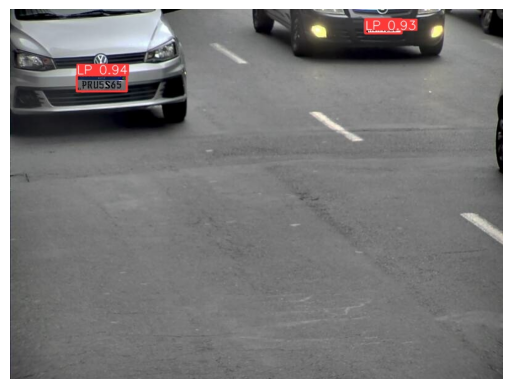

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def print_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Optional: Turn off axis ticks and labels
    plt.show()

# Example usage
image_path = "runs/detect/predict/monitoring_system_1819.JPG"
print_image(image_path)


In [19]:
import zipfile
import os

def zip_folder(source_folder, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(source_folder):
            for file in files:
                file_path = os.path.join(root, file)
                # Adding the file to the zip archive with the relative path
                zipf.write(file_path, os.path.relpath(file_path, source_folder))

# Replace 'path_to_source_folder' with the path of the folder you want to zip
source_folder = '/kaggle/working/runs/detect/train2'
# Replace 'output_zip_file.zip' with the desired name for the output zip file
output_zip_file = 'output_zip_file.zip'

zip_folder(source_folder, output_zip_file)
print("Folder zipped and saved successfully.")


Folder zipped and saved successfully.


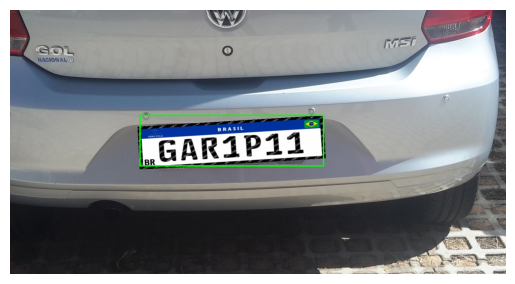

In [21]:
import cv2
from matplotlib import pyplot as plt

def cv2_imshow(image):
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
img = cv2.imread('/kaggle/input/dataset-license/test_dataset/test_dataset/images/175.JPG')
img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
cv2_imshow(img)


In [28]:
# os.mkdir("/kaggle/working/cropped")

In [7]:
def get_dim(img_path, dim_path):
    lis = open(dim_path,'r').readlines()
    for li in lis:
        l = li.split()
        xc,yc,nw,nh = float(l[1]),float(l[2]),float(l[3]),float(l[4])
    img = cv2.imread(img_path)
    h , w = img.shape[0],img.shape[1]
    xc *= w
    yc *= h
    nw *= w
    nh *= h
    tl = (int(xc - nw/2),int(yc - nh/2))
    br = (int(xc+nw/2),int(yc +nh/2))
    return tl, br

In [8]:
from PIL import Image

def crop_image(image, top_left, bottom_right, output_path):
    try:
        left, top = top_left
        right, bottom = bottom_right
        cropped_image = image.crop((left, top, right, bottom))        
        return cropped_image

    except Exception as e:
        print(f"Error while cropping the image: {e}")


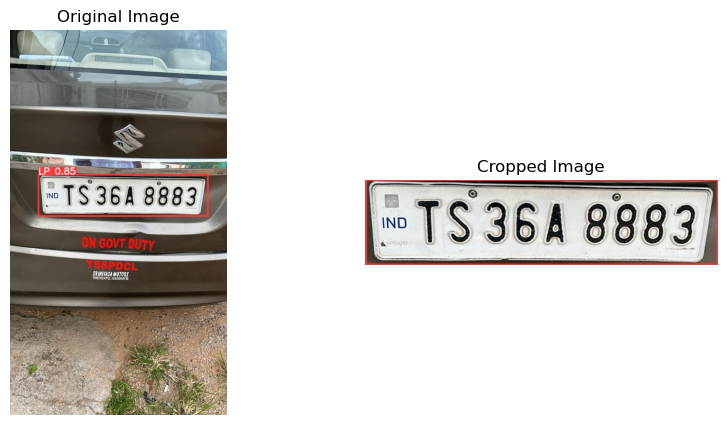

Image cropped and saved successfully.


In [12]:

# image_num = "175" #change here for new image
# img_path = "/kaggle/input/dataset-license/test_dataset/test_dataset/images/"+image_num+".JPG"
# dim_path = "/kaggle/working/runs/detect/predict2/labels/"+image_num+".txt"
# output_path = "/kaggle/working/cropped/"+image_num+".jpg"


img_path = "/kaggle/working/runs/detect/predict/IMG-20230809-WA0000.jpg"
dim_path = "/kaggle/working/runs/detect/predict/labels/IMG-20230809-WA0000.txt"
output_path = "/kaggle/working/"+"SwathiCar"+".jpg"


image = Image.open(img_path)
top_left,bottom_right =  get_dim(img_path, dim_path)
cropped_image = crop_image(image, top_left, bottom_right, output_path)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_image)
plt.title("Cropped Image")
plt.axis('off')
plt.savefig("ouptut.jpg", dpi=600)
plt.show()

print("Image cropped and saved successfully.")
cropped_image.save(output_path)


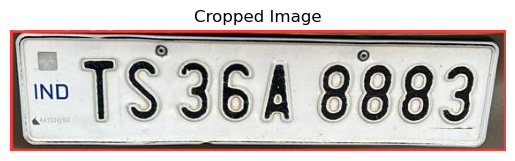

In [13]:
plt.imshow(cropped_image)
plt.title("Cropped Image")
plt.axis('off')
plt.savefig("cropped_image", dpi=600)
plt.show()

In [21]:
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')
            plt.axis('off')
            plt.savefig("segmented.jpg", dpi=600)


            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [24]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.axis('off')
    plt.savefig("cont.jpg", dpi=600)

    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

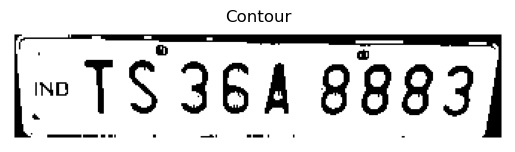

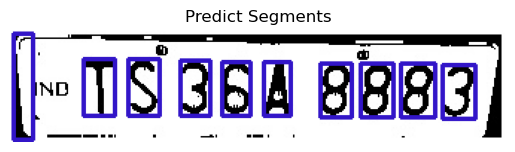

In [25]:
cropped = np.array(cropped_image)
char=segment_characters(cropped)

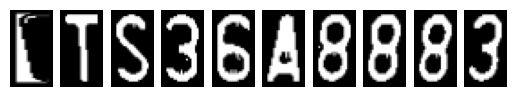

In [18]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
    plt.savefig("divided.jpg", dpi=600)
plt.show()

In [20]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((224,224,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): 
        img_ = cv2.resize(ch, (224,224), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,224,224,3) 
        y_ = model.predict(img) 
        y_class = np.argmax(y_)
        print(y_class)        
        character = dic[y_class]
        output.append(character)
    plate_number = ''.join(output)
    return plate_number

print(show_results())

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:3699: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


In [26]:
print(y_)

NameError: name 'y_' is not defined

In [3]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (224,224), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

NameError: name 'char' is not defined

<Figure size 1000x600 with 0 Axes>

# Resnet_model

In [2]:
import matplotlib.gridspec as gridspec
# from local_utils import detect_lp
from os.path import splitext, basename
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
json_file = open('/kaggle/input/dataset-license/Resnet_loaded_model/Resnet_loaded_model/Resnet_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/kaggle/input/dataset-license/Resnet_loaded_model/Resnet_loaded_model/License_character_recognition.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('/kaggle/input/dataset-license/Resnet_loaded_model/Resnet_loaded_model/license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [4]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

1/1 [==============================] - 0s 22ms/step
GAR1P11


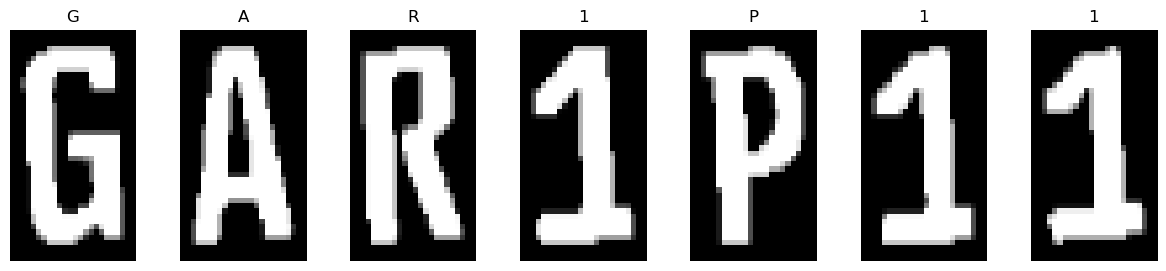

In [37]:
fig = plt.figure(figsize=(15,3))
cols = len(char)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(char):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)

# Test-Dataset

In [42]:
labels_test=pd.read_excel('/kaggle/input/dataset-license/test_dataset/test_dataset/labels.xlsx')
labels_test['ID']=labels_test['ID'].map(str)
labels_test

ID       NUMBER
0      1    KL55R2473
1      2  GJW115A1138
2      3    KL16J3636
3      4   MH20EE7598
4      5      PJJ1L76
..   ...          ...
181  182      DHF5B15
182  183      DBJ5R59
183  184      LVY8X45
184  185      YYD6B61
185  186      CHI4A30

[186 rows x 2 columns]

# Cropping all Images

In [5]:
def get_dim(img_path, dim_path):
    lis = open(dim_path,'r').readlines()
    for li in lis:
        l = li.split()
        xc,yc,nw,nh = float(l[1]),float(l[2]),float(l[3]),float(l[4])
    img = cv2.imread(img_path)
    h , w = img.shape[0],img.shape[1]
    xc *= w
    yc *= h
    nw *= w
    nh *= h
    tl = (int(xc - nw/2),int(yc - nh/2))
    br = (int(xc+nw/2),int(yc +nh/2))
    return tl, br

In [6]:
from PIL import Image

def crop_image(image, top_left, bottom_right, output_path):
    try:
        left, top = top_left
        right, bottom = bottom_right
        cropped_image = image.crop((left, top, right, bottom))        
        return cropped_image

    except Exception as e:
        print(f"Error while cropping the image: {e}")


In [61]:
import re
directory_path = '/kaggle/input/dataset-license/Indian_plate/images'
file_list = os.listdir(directory_path)
for file_name in file_list:
    if file_name.lower().endswith('.png'):
        continue
    file_name = '/kaggle/input/dataset-license/test_dataset/test_dataset/images/' + file_name
    pattern = r'\d+'
    match = re.search(pattern, file_name)
    image_num = match.group()
    img_path = file_name
    dim_path = "/kaggle/working/runs/detect/predict2/labels/"+image_num+".txt"
    if not os.path.exists(dim_path):
            print(f"File not found: {dim_path}")
            continue
    output_path = "/kaggle/working/cropped/"+image_num+".jpg"
    image = Image.open(img_path)
    top_left,bottom_right =  get_dim(img_path, dim_path)
    cropped_image = crop_image(image, top_left, bottom_right, output_path)
    print("saved at", output_path)
    cropped_image.save(output_path)


saved at /kaggle/working/cropped/56.jpg
saved at /kaggle/working/cropped/89.jpg
saved at /kaggle/working/cropped/58.jpg
saved at /kaggle/working/cropped/150.jpg
saved at /kaggle/working/cropped/6.jpg
saved at /kaggle/working/cropped/109.jpg
saved at /kaggle/working/cropped/149.jpg
saved at /kaggle/working/cropped/76.jpg
saved at /kaggle/working/cropped/71.jpg
saved at /kaggle/working/cropped/182.jpg
saved at /kaggle/working/cropped/185.jpg
saved at /kaggle/working/cropped/153.jpg
saved at /kaggle/working/cropped/143.jpg
saved at /kaggle/working/cropped/131.jpg
saved at /kaggle/working/cropped/5.jpg
saved at /kaggle/working/cropped/151.jpg
File not found: /kaggle/working/runs/detect/predict2/labels/8.txt
File not found: /kaggle/working/runs/detect/predict2/labels/84.txt
saved at /kaggle/working/cropped/118.jpg
saved at /kaggle/working/cropped/82.jpg
saved at /kaggle/working/cropped/176.jpg
saved at /kaggle/working/cropped/30.jpg
saved at /kaggle/working/cropped/163.jpg
saved at /kaggle/

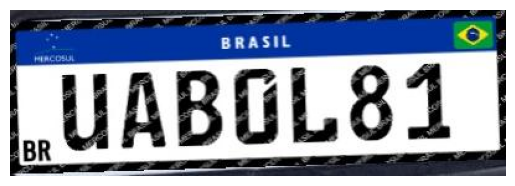

In [63]:
# import matplotlib.pyplot as plt
# from PIL import Image

# image_path = '/kaggle/working/cropped/136.jpg'
# image = Image.open(image_path)

# plt.imshow(image)
# plt.axis('off')  
# plt.show()


# Finding string

In [64]:
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [65]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

# Loading Model

In [67]:
json_file = open('/kaggle/input/dataset-license/Resnet_loaded_model/Resnet_loaded_model/Resnet_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/kaggle/input/dataset-license/Resnet_loaded_model/Resnet_loaded_model/License_character_recognition.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('/kaggle/input/dataset-license/Resnet_loaded_model/Resnet_loaded_model/license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


# Predicting 

In [76]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

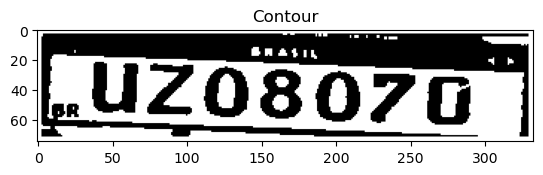

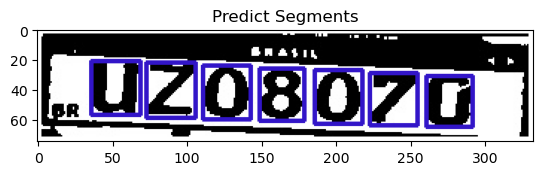

1/1 [==============================] - 1s 926ms/step
U
1/1 [==============================] - 0s 24ms/step
UZ
1/1 [==============================] - 0s 22ms/step
UZ0
1/1 [==============================] - 0s 23ms/step
UZ08
1/1 [==============================] - 0s 22ms/step
UZ080
1/1 [==============================] - 0s 21ms/step
UZ0807
1/1 [==============================] - 0s 21ms/step
UZ08070


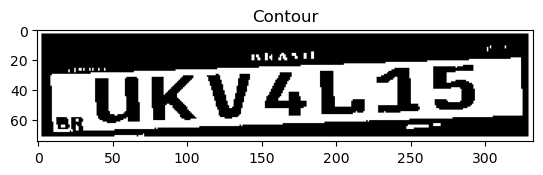

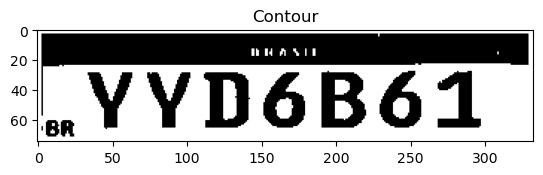

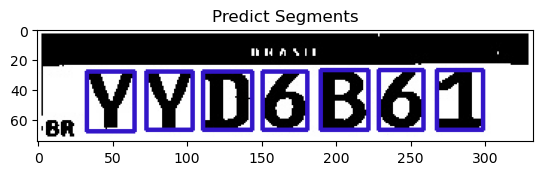

1/1 [==============================] - 0s 24ms/step
Y
1/1 [==============================] - 0s 24ms/step
YY
1/1 [==============================] - 0s 39ms/step
YYD
1/1 [==============================] - 0s 35ms/step
YYD6
1/1 [==============================] - 0s 23ms/step
YYD6B
1/1 [==============================] - 0s 24ms/step
YYD6B6
1/1 [==============================] - 0s 23ms/step
YYD6B61


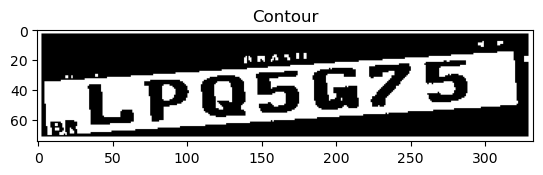

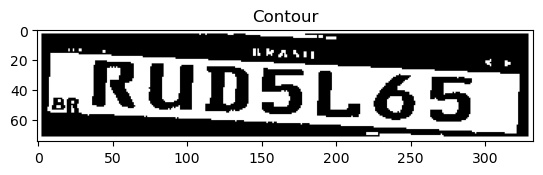

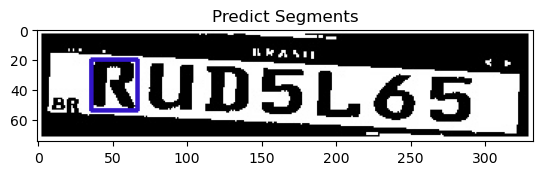

1/1 [==============================] - 0s 24ms/step
R


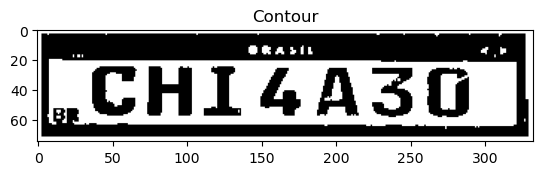

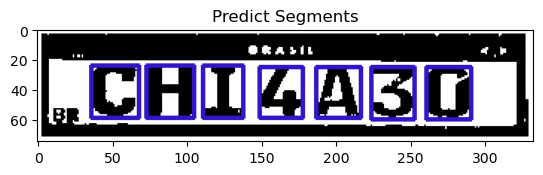

1/1 [==============================] - 0s 26ms/step
C
1/1 [==============================] - 0s 22ms/step
CH
1/1 [==============================] - 0s 22ms/step
CHI
1/1 [==============================] - 0s 22ms/step
CHI4
1/1 [==============================] - 0s 22ms/step
CHI4A
1/1 [==============================] - 0s 22ms/step
CHI4A3
1/1 [==============================] - 0s 22ms/step
CHI4A30


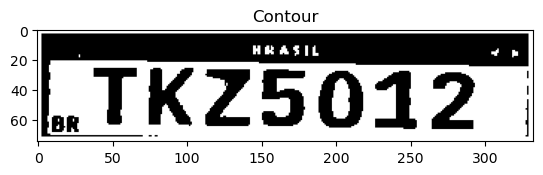

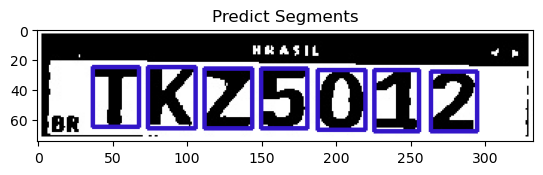

1/1 [==============================] - 0s 23ms/step
T
1/1 [==============================] - 0s 23ms/step
TK
1/1 [==============================] - 0s 22ms/step
TKZ
1/1 [==============================] - 0s 22ms/step
TKZ5
1/1 [==============================] - 0s 24ms/step
TKZ50
1/1 [==============================] - 0s 23ms/step
TKZ501
1/1 [==============================] - 0s 24ms/step
TKZ5012


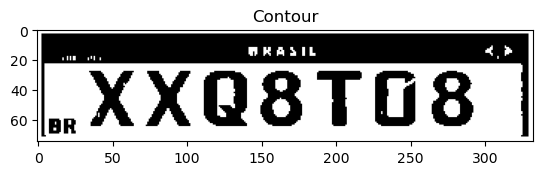

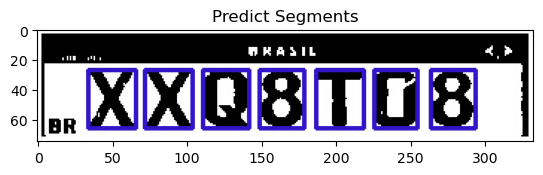

1/1 [==============================] - 0s 23ms/step
X
1/1 [==============================] - 0s 22ms/step
XX
1/1 [==============================] - 0s 21ms/step
XXQ
1/1 [==============================] - 0s 26ms/step
XXQ8
1/1 [==============================] - 0s 23ms/step
XXQ8T
1/1 [==============================] - 0s 23ms/step
XXQ8T0
1/1 [==============================] - 0s 25ms/step
XXQ8T08


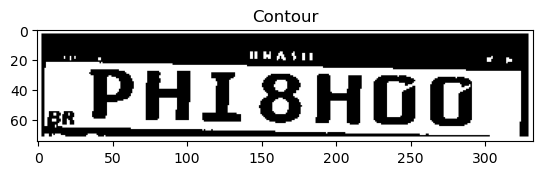

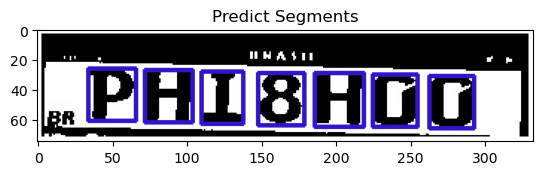

1/1 [==============================] - 0s 24ms/step
P
1/1 [==============================] - 0s 24ms/step
PH
1/1 [==============================] - 0s 22ms/step
PHI
1/1 [==============================] - 0s 23ms/step
PHI8
1/1 [==============================] - 0s 21ms/step
PHI8H
1/1 [==============================] - 0s 23ms/step
PHI8HG
1/1 [==============================] - 0s 21ms/step
PHI8HGG


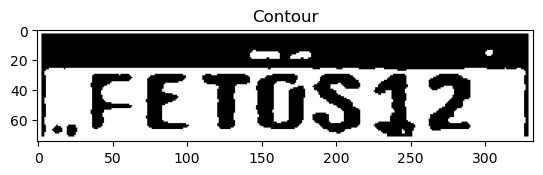

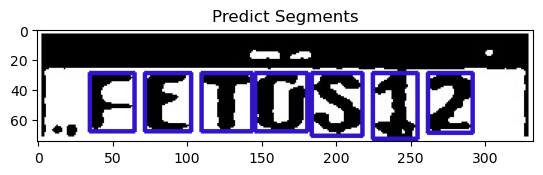

1/1 [==============================] - 0s 23ms/step
F
1/1 [==============================] - 0s 22ms/step
FE
1/1 [==============================] - 0s 23ms/step
FET
1/1 [==============================] - 0s 23ms/step
FETG
1/1 [==============================] - 0s 23ms/step
FETGS
1/1 [==============================] - 0s 24ms/step
FETGS1
1/1 [==============================] - 0s 24ms/step
FETGS12


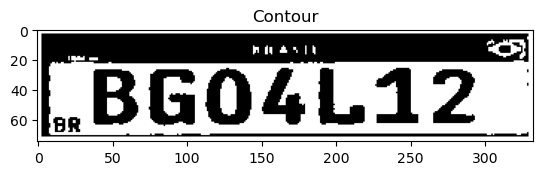

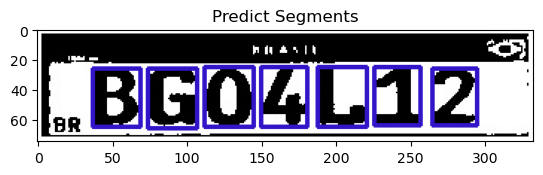

1/1 [==============================] - 0s 22ms/step
B
1/1 [==============================] - 0s 22ms/step
BG
1/1 [==============================] - 0s 23ms/step
BG0
1/1 [==============================] - 0s 24ms/step
BG04
1/1 [==============================] - 0s 22ms/step
BG04L
1/1 [==============================] - 0s 21ms/step
BG04L1
1/1 [==============================] - 0s 23ms/step
BG04L12


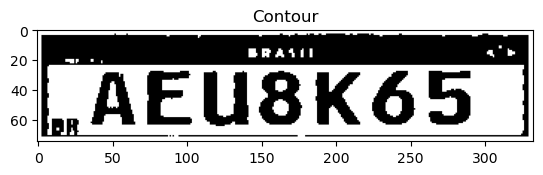

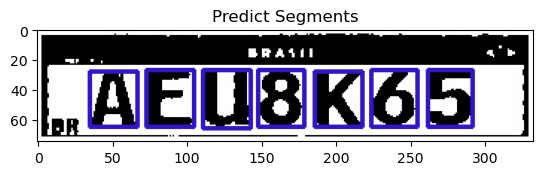

1/1 [==============================] - 0s 25ms/step
A
1/1 [==============================] - 0s 26ms/step
AE
1/1 [==============================] - 0s 25ms/step
AEU
1/1 [==============================] - 0s 23ms/step
AEU8
1/1 [==============================] - 0s 22ms/step
AEU8K
1/1 [==============================] - 0s 22ms/step
AEU8K6
1/1 [==============================] - 0s 21ms/step
AEU8K65


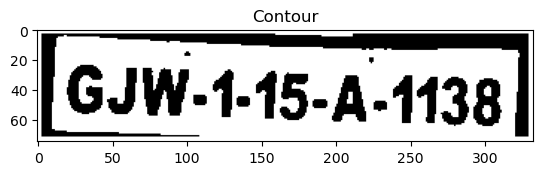

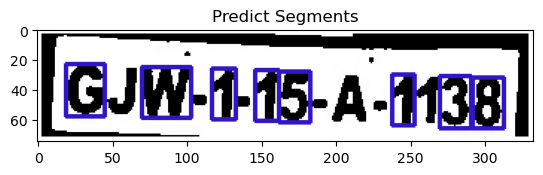

1/1 [==============================] - 0s 24ms/step
G
1/1 [==============================] - 0s 23ms/step
GW
1/1 [==============================] - 0s 22ms/step
GW1
1/1 [==============================] - 0s 22ms/step
GW11
1/1 [==============================] - 0s 21ms/step
GW115
1/1 [==============================] - 0s 23ms/step
GW1151
1/1 [==============================] - 0s 23ms/step
GW11513
1/1 [==============================] - 0s 22ms/step
GW115138


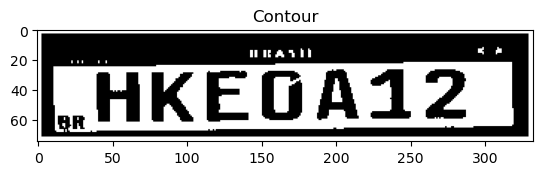

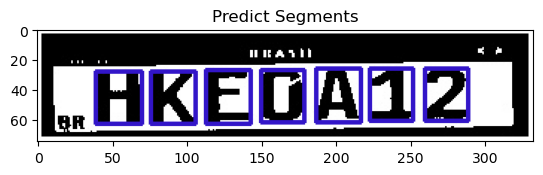

1/1 [==============================] - 0s 35ms/step
H
1/1 [==============================] - 0s 36ms/step
HK
1/1 [==============================] - 0s 35ms/step
HKE
1/1 [==============================] - 0s 34ms/step
HKEG
1/1 [==============================] - 0s 34ms/step
HKEGA
1/1 [==============================] - 0s 32ms/step
HKEGA1
1/1 [==============================] - 0s 35ms/step
HKEGA12


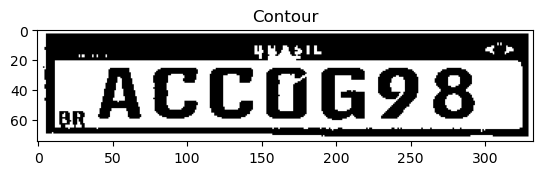

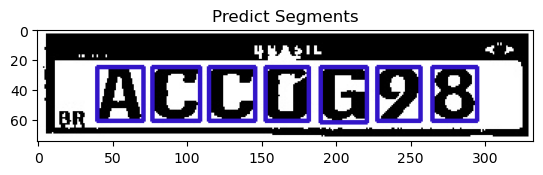

1/1 [==============================] - 0s 24ms/step
A
1/1 [==============================] - 0s 22ms/step
AC
1/1 [==============================] - 0s 24ms/step
ACC
1/1 [==============================] - 0s 25ms/step
ACCG
1/1 [==============================] - 0s 23ms/step
ACCGG
1/1 [==============================] - 0s 26ms/step
ACCGG9
1/1 [==============================] - 0s 23ms/step
ACCGG98


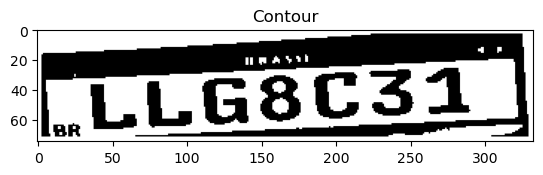

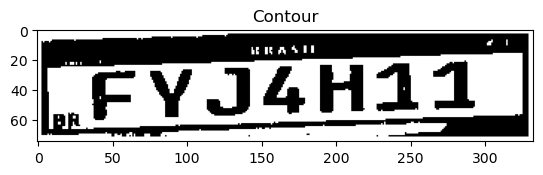

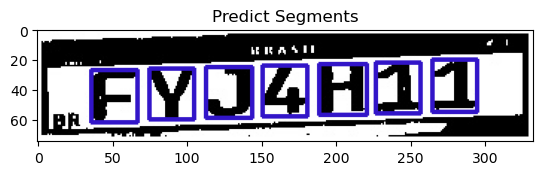

1/1 [==============================] - 0s 24ms/step
F
1/1 [==============================] - 0s 22ms/step
FY
1/1 [==============================] - 0s 23ms/step
FYJ
1/1 [==============================] - 0s 25ms/step
FYJ4
1/1 [==============================] - 0s 24ms/step
FYJ4H
1/1 [==============================] - 0s 23ms/step
FYJ4H1
1/1 [==============================] - 0s 22ms/step
FYJ4H11


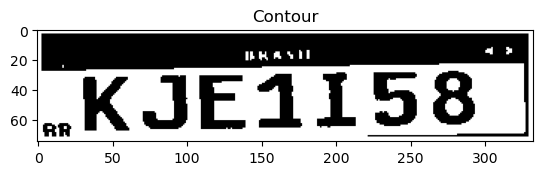

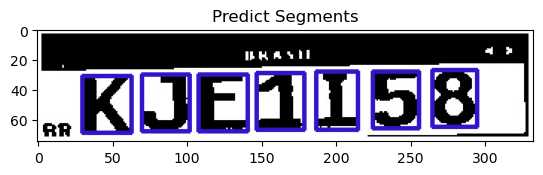

1/1 [==============================] - 0s 25ms/step
K
1/1 [==============================] - 0s 27ms/step
KJ
1/1 [==============================] - 0s 23ms/step
KJE
1/1 [==============================] - 0s 24ms/step
KJE1
1/1 [==============================] - 0s 23ms/step
KJE1I
1/1 [==============================] - 0s 22ms/step
KJE1I5
1/1 [==============================] - 0s 23ms/step
KJE1I58


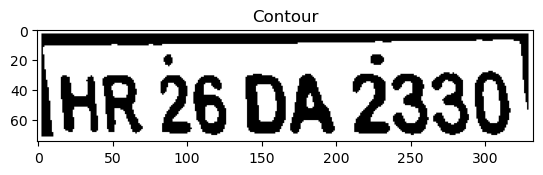

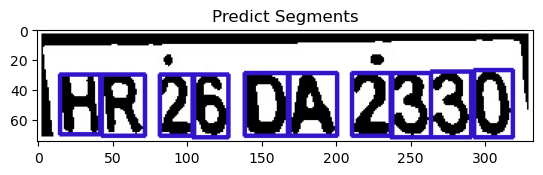

1/1 [==============================] - 0s 24ms/step
H
1/1 [==============================] - 0s 22ms/step
HR
1/1 [==============================] - 0s 22ms/step
HR2
1/1 [==============================] - 0s 23ms/step
HR26
1/1 [==============================] - 0s 23ms/step
HR260
1/1 [==============================] - 0s 21ms/step
HR260A
1/1 [==============================] - 0s 23ms/step
HR260A2
1/1 [==============================] - 0s 24ms/step
HR260A23
1/1 [==============================] - 0s 23ms/step
HR260A233
1/1 [==============================] - 0s 26ms/step
HR260A2330


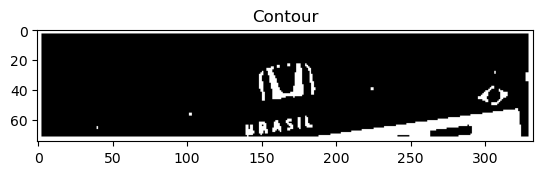

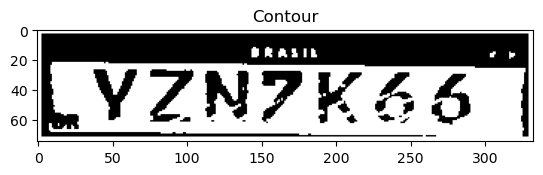

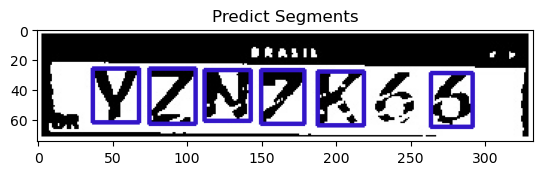

1/1 [==============================] - 0s 24ms/step
Y
1/1 [==============================] - 0s 24ms/step
YZ
1/1 [==============================] - 0s 23ms/step
YZN
1/1 [==============================] - 0s 24ms/step
YZN7
1/1 [==============================] - 0s 23ms/step
YZN7K
1/1 [==============================] - 0s 23ms/step
YZN7K6


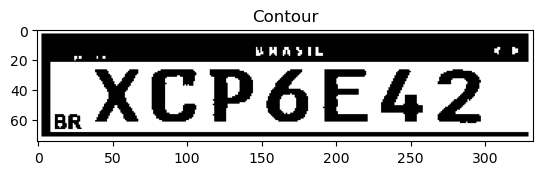

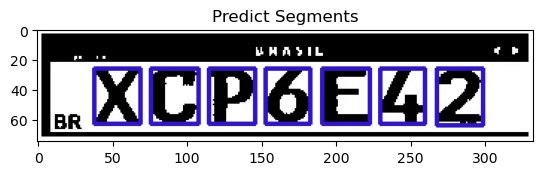

1/1 [==============================] - 0s 24ms/step
X
1/1 [==============================] - 0s 24ms/step
XC
1/1 [==============================] - 0s 22ms/step
XCP
1/1 [==============================] - 0s 26ms/step
XCP6
1/1 [==============================] - 0s 24ms/step
XCP6E
1/1 [==============================] - 0s 22ms/step
XCP6E4
1/1 [==============================] - 0s 24ms/step
XCP6E42


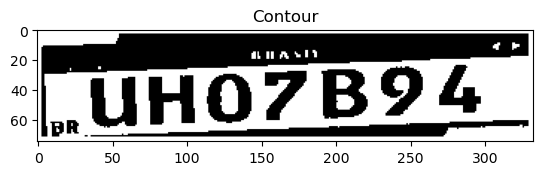

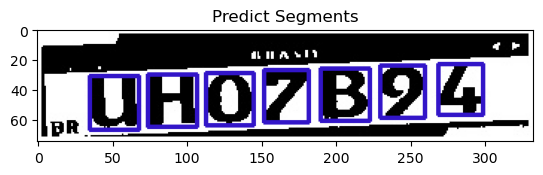

1/1 [==============================] - 0s 23ms/step
U
1/1 [==============================] - 0s 24ms/step
UH
1/1 [==============================] - 0s 22ms/step
UH0
1/1 [==============================] - 0s 23ms/step
UH07
1/1 [==============================] - 0s 23ms/step
UH07B
1/1 [==============================] - 0s 23ms/step
UH07B9
1/1 [==============================] - 0s 22ms/step
UH07B94


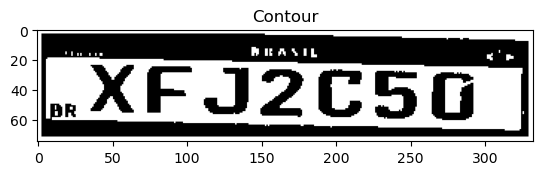

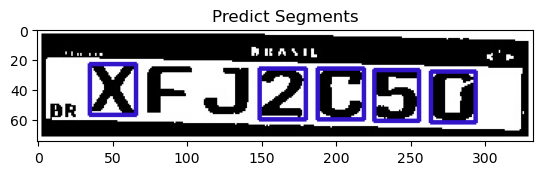

1/1 [==============================] - 0s 23ms/step
X
1/1 [==============================] - 0s 22ms/step
X2
1/1 [==============================] - 0s 21ms/step
X2C
1/1 [==============================] - 0s 23ms/step
X2C5
1/1 [==============================] - 0s 24ms/step
X2C5G


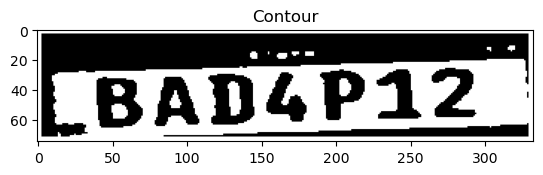

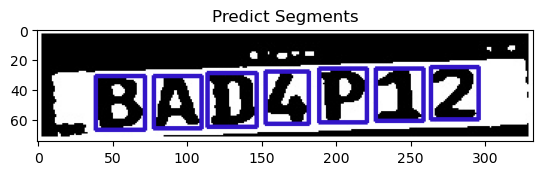

1/1 [==============================] - 0s 24ms/step
B
1/1 [==============================] - 0s 22ms/step
BA
1/1 [==============================] - 0s 22ms/step
BAD
1/1 [==============================] - 0s 24ms/step
BAD4
1/1 [==============================] - 0s 22ms/step
BAD4P
1/1 [==============================] - 0s 22ms/step
BAD4P1
1/1 [==============================] - 0s 24ms/step
BAD4P12


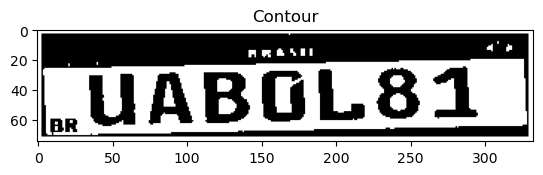

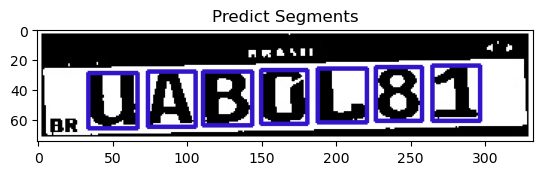

1/1 [==============================] - 0s 23ms/step
U
1/1 [==============================] - 0s 22ms/step
UA
1/1 [==============================] - 0s 22ms/step
UAB
1/1 [==============================] - 0s 22ms/step
UAB0
1/1 [==============================] - 0s 26ms/step
UAB0L
1/1 [==============================] - 0s 24ms/step
UAB0L8
1/1 [==============================] - 0s 25ms/step
UAB0L81


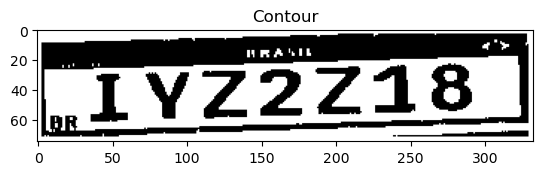

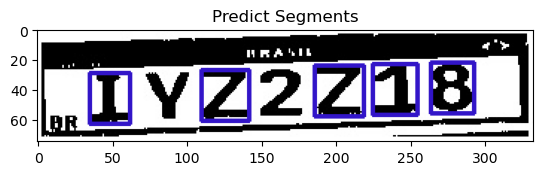

1/1 [==============================] - 0s 24ms/step
I
1/1 [==============================] - 0s 21ms/step
IZ
1/1 [==============================] - 0s 22ms/step
IZZ
1/1 [==============================] - 0s 21ms/step
IZZ1
1/1 [==============================] - 0s 21ms/step
IZZ18


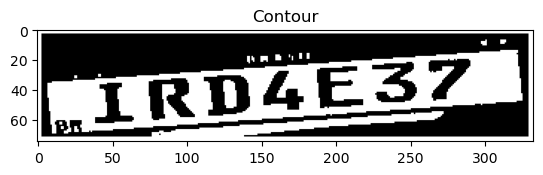

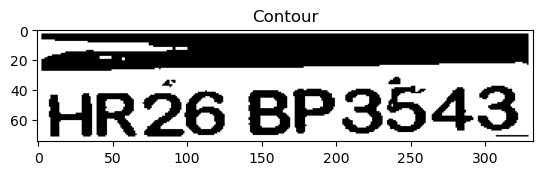

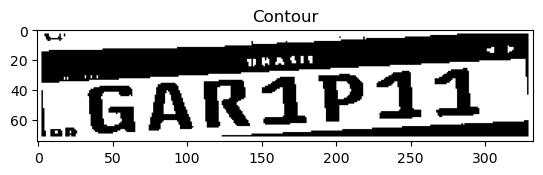

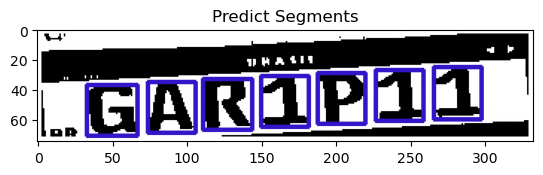

1/1 [==============================] - 0s 25ms/step
G
1/1 [==============================] - 0s 23ms/step
GA
1/1 [==============================] - 0s 23ms/step
GAR
1/1 [==============================] - 0s 23ms/step
GAR1
1/1 [==============================] - 0s 23ms/step
GAR1P
1/1 [==============================] - 0s 22ms/step
GAR1P1
1/1 [==============================] - 0s 22ms/step
GAR1P11


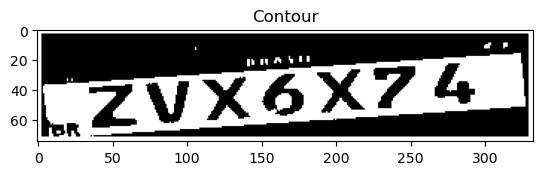

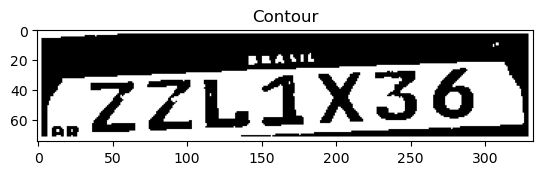

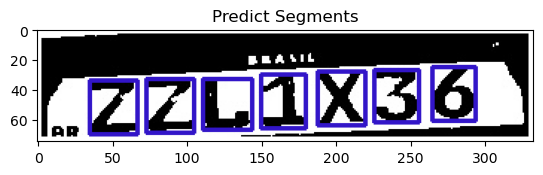

1/1 [==============================] - 0s 24ms/step
Z
1/1 [==============================] - 0s 22ms/step
ZZ
1/1 [==============================] - 0s 24ms/step
ZZL
1/1 [==============================] - 0s 22ms/step
ZZL1
1/1 [==============================] - 0s 23ms/step
ZZL1X
1/1 [==============================] - 0s 24ms/step
ZZL1X3
1/1 [==============================] - 0s 23ms/step
ZZL1X36


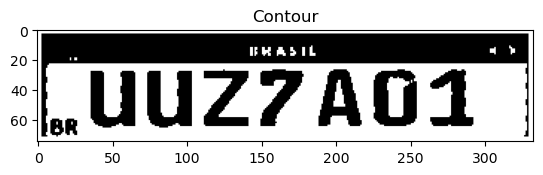

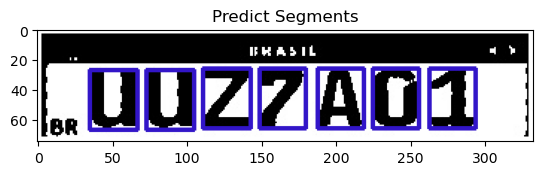

1/1 [==============================] - 0s 23ms/step
U
1/1 [==============================] - 0s 24ms/step
UU
1/1 [==============================] - 0s 22ms/step
UUZ
1/1 [==============================] - 0s 24ms/step
UUZ7
1/1 [==============================] - 0s 25ms/step
UUZ7A
1/1 [==============================] - 0s 24ms/step
UUZ7A0
1/1 [==============================] - 0s 24ms/step
UUZ7A01


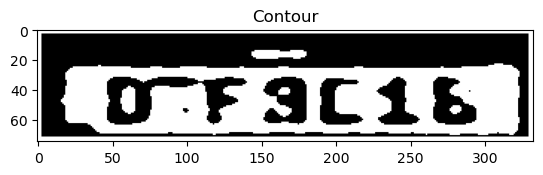

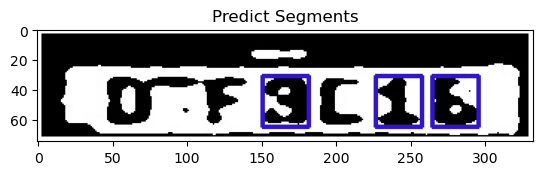

1/1 [==============================] - 0s 26ms/step
9
1/1 [==============================] - 0s 25ms/step
91
1/1 [==============================] - 0s 25ms/step
916


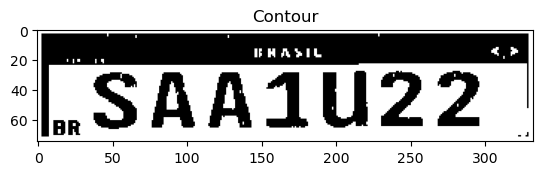

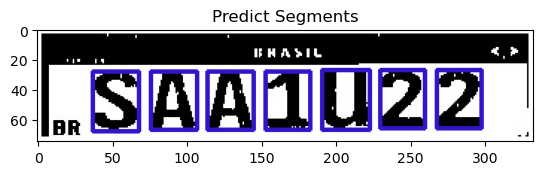

1/1 [==============================] - 0s 24ms/step
S
1/1 [==============================] - 0s 23ms/step
SA
1/1 [==============================] - 0s 24ms/step
SAA
1/1 [==============================] - 0s 22ms/step
SAA1
1/1 [==============================] - 0s 23ms/step
SAA1U
1/1 [==============================] - 0s 25ms/step
SAA1U2
1/1 [==============================] - 0s 25ms/step
SAA1U22


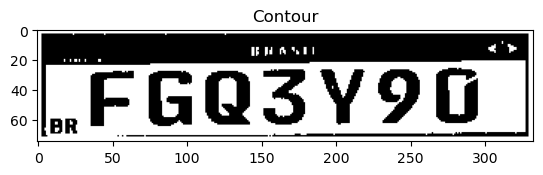

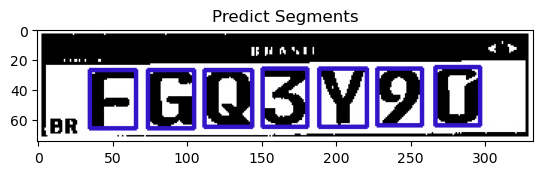

1/1 [==============================] - 0s 23ms/step
F
1/1 [==============================] - 0s 23ms/step
FG
1/1 [==============================] - 0s 23ms/step
FGQ
1/1 [==============================] - 0s 23ms/step
FGQ3
1/1 [==============================] - 0s 23ms/step
FGQ3Y
1/1 [==============================] - 0s 23ms/step
FGQ3Y9
1/1 [==============================] - 0s 23ms/step
FGQ3Y9G


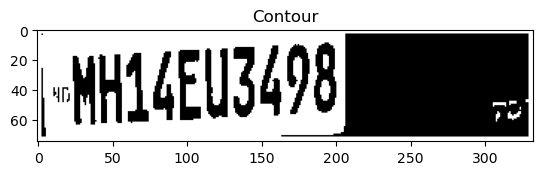

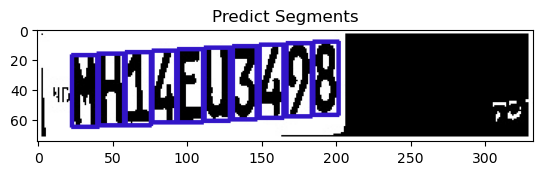

1/1 [==============================] - 0s 25ms/step
M
1/1 [==============================] - 0s 24ms/step
MH
1/1 [==============================] - 0s 22ms/step
MH1
1/1 [==============================] - 0s 24ms/step
MH14
1/1 [==============================] - 0s 24ms/step
MH14E
1/1 [==============================] - 0s 24ms/step
MH14EU
1/1 [==============================] - 0s 24ms/step
MH14EU3
1/1 [==============================] - 0s 24ms/step
MH14EU34
1/1 [==============================] - 0s 26ms/step
MH14EU349
1/1 [==============================] - 0s 25ms/step
MH14EU3498


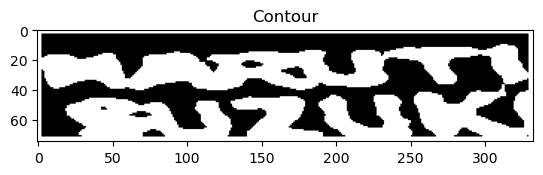

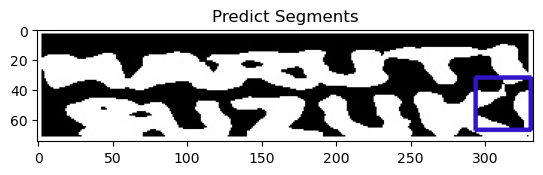

1/1 [==============================] - 0s 24ms/step
X


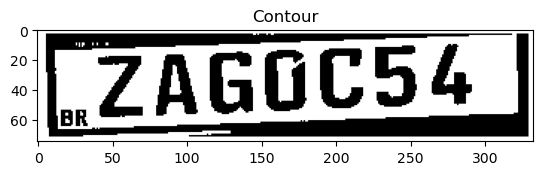

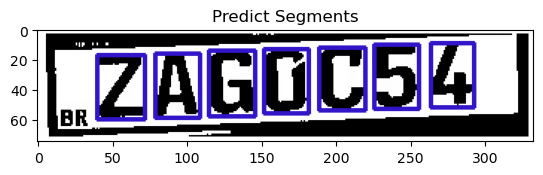

1/1 [==============================] - 0s 23ms/step
Z
1/1 [==============================] - 0s 22ms/step
ZA
1/1 [==============================] - 0s 22ms/step
ZAG
1/1 [==============================] - 0s 24ms/step
ZAGG
1/1 [==============================] - 0s 24ms/step
ZAGGC
1/1 [==============================] - 0s 29ms/step
ZAGGC5
1/1 [==============================] - 0s 28ms/step
ZAGGC54


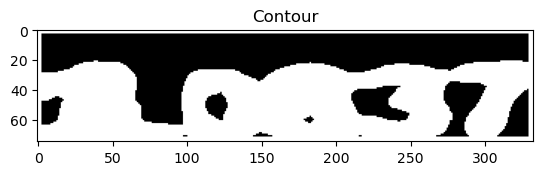

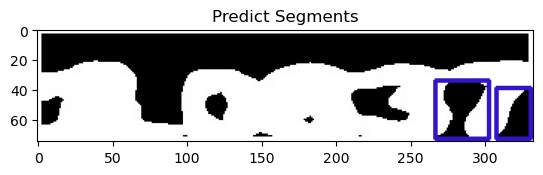

1/1 [==============================] - 0s 30ms/step
1
1/1 [==============================] - 0s 28ms/step
1L


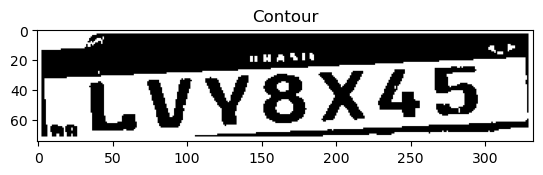

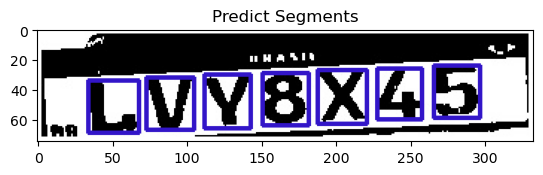

1/1 [==============================] - 0s 29ms/step
L
1/1 [==============================] - 0s 26ms/step
LV
1/1 [==============================] - 0s 25ms/step
LVY
1/1 [==============================] - 0s 24ms/step
LVY8
1/1 [==============================] - 0s 25ms/step
LVY8X
1/1 [==============================] - 0s 25ms/step
LVY8X4
1/1 [==============================] - 0s 26ms/step
LVY8X45


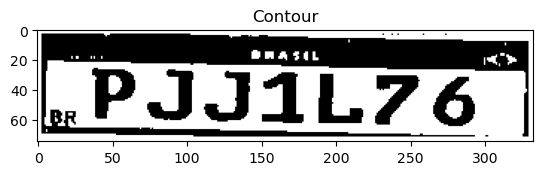

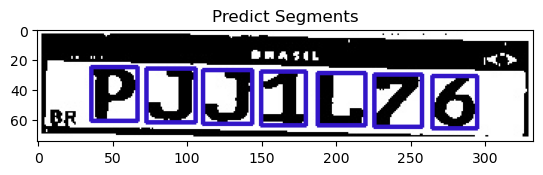

1/1 [==============================] - 0s 38ms/step
P
1/1 [==============================] - 0s 39ms/step
PJ
1/1 [==============================] - 0s 40ms/step
PJJ
1/1 [==============================] - 0s 47ms/step
PJJ1
1/1 [==============================] - 0s 47ms/step
PJJ1L
1/1 [==============================] - 0s 36ms/step
PJJ1L7
1/1 [==============================] - 0s 39ms/step
PJJ1L76


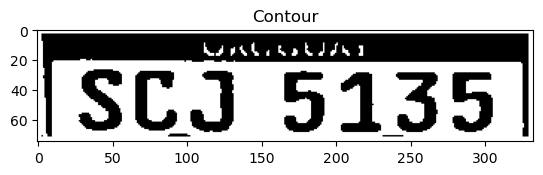

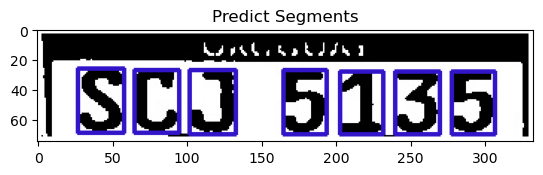

1/1 [==============================] - 0s 27ms/step
S
1/1 [==============================] - 0s 24ms/step
SC
1/1 [==============================] - 0s 26ms/step
SCJ
1/1 [==============================] - 0s 27ms/step
SCJ5
1/1 [==============================] - 0s 24ms/step
SCJ51
1/1 [==============================] - 0s 24ms/step
SCJ513
1/1 [==============================] - 0s 23ms/step
SCJ5135


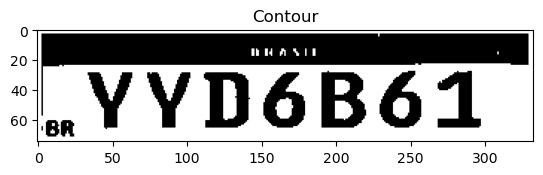

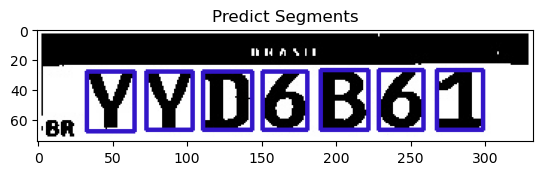

1/1 [==============================] - 0s 25ms/step
Y
1/1 [==============================] - 0s 24ms/step
YY
1/1 [==============================] - 0s 23ms/step
YYD
1/1 [==============================] - 0s 23ms/step
YYD6
1/1 [==============================] - 0s 24ms/step
YYD6B
1/1 [==============================] - 0s 23ms/step
YYD6B6
1/1 [==============================] - 0s 24ms/step
YYD6B61


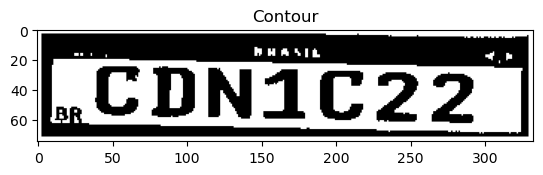

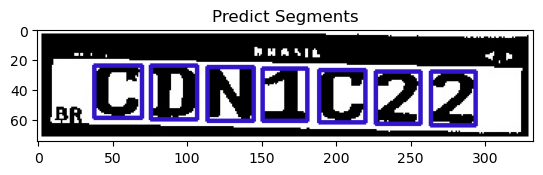

1/1 [==============================] - 0s 27ms/step
C
1/1 [==============================] - 0s 27ms/step
CD
1/1 [==============================] - 0s 26ms/step
CDN
1/1 [==============================] - 0s 26ms/step
CDN1
1/1 [==============================] - 0s 26ms/step
CDN1C
1/1 [==============================] - 0s 25ms/step
CDN1C2
1/1 [==============================] - 0s 25ms/step
CDN1C22


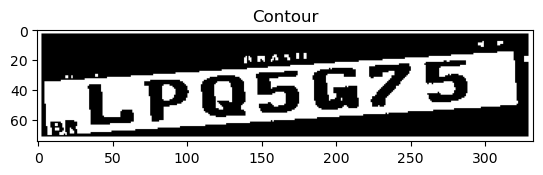

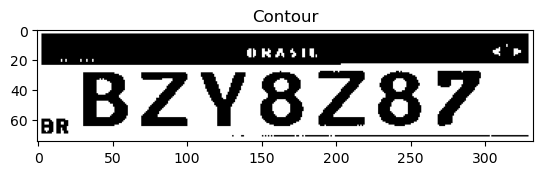

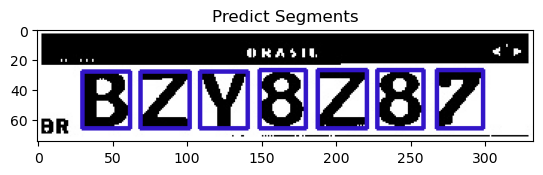

1/1 [==============================] - 0s 24ms/step
B
1/1 [==============================] - 0s 24ms/step
BZ
1/1 [==============================] - 0s 23ms/step
BZY
1/1 [==============================] - 0s 25ms/step
BZY8
1/1 [==============================] - 0s 26ms/step
BZY8Z
1/1 [==============================] - 0s 25ms/step
BZY8Z8
1/1 [==============================] - 0s 26ms/step
BZY8Z87


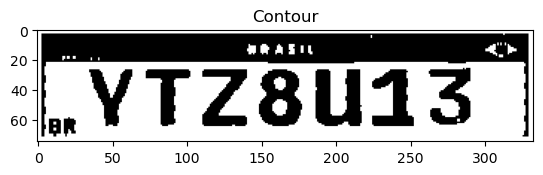

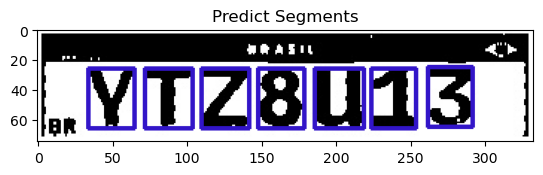

1/1 [==============================] - 0s 26ms/step
V
1/1 [==============================] - 0s 25ms/step
VT
1/1 [==============================] - 0s 24ms/step
VTZ
1/1 [==============================] - 0s 24ms/step
VTZ8
1/1 [==============================] - 0s 24ms/step
VTZ8U
1/1 [==============================] - 0s 22ms/step
VTZ8U1
1/1 [==============================] - 0s 22ms/step
VTZ8U13


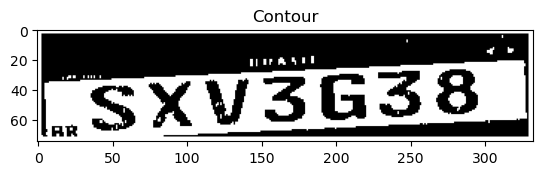

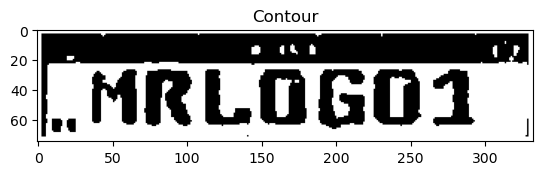

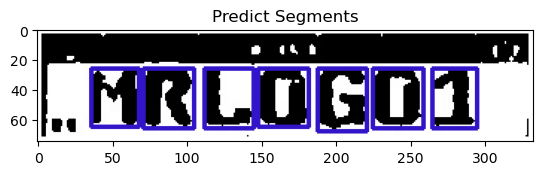

1/1 [==============================] - 0s 24ms/step
M
1/1 [==============================] - 0s 22ms/step
MR
1/1 [==============================] - 0s 23ms/step
MRL
1/1 [==============================] - 0s 26ms/step
MRL0
1/1 [==============================] - 0s 25ms/step
MRL0G
1/1 [==============================] - 0s 26ms/step
MRL0G0
1/1 [==============================] - 0s 23ms/step
MRL0G01


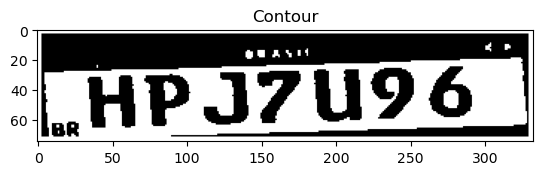

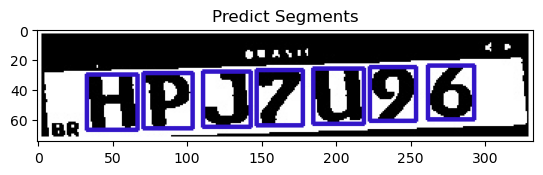

1/1 [==============================] - 0s 24ms/step
H
1/1 [==============================] - 0s 69ms/step
HP
1/1 [==============================] - 0s 25ms/step
HPJ
1/1 [==============================] - 0s 23ms/step
HPJ7
1/1 [==============================] - 0s 22ms/step
HPJ7U
1/1 [==============================] - 0s 22ms/step
HPJ7U9
1/1 [==============================] - 0s 23ms/step
HPJ7U96


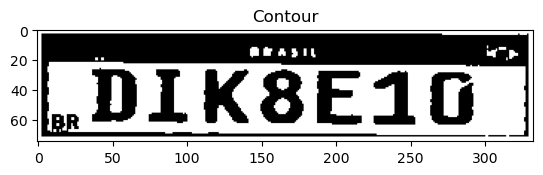

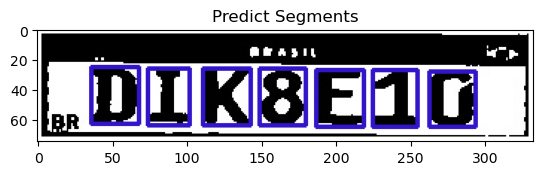

1/1 [==============================] - 0s 24ms/step
D
1/1 [==============================] - 0s 22ms/step
DI
1/1 [==============================] - 0s 21ms/step
DIK
1/1 [==============================] - 0s 21ms/step
DIK8
1/1 [==============================] - 0s 25ms/step
DIK8E
1/1 [==============================] - 0s 26ms/step
DIK8E1
1/1 [==============================] - 0s 24ms/step
DIK8E1G


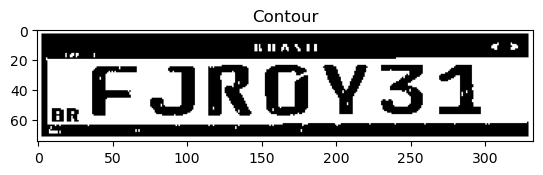

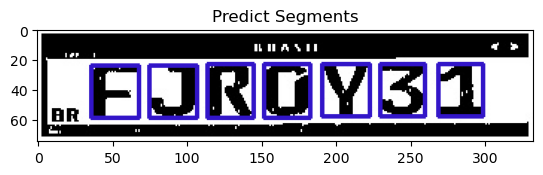

1/1 [==============================] - 0s 25ms/step
F
1/1 [==============================] - 0s 24ms/step
FJ
1/1 [==============================] - 0s 22ms/step
FJR
1/1 [==============================] - 0s 25ms/step
FJRG
1/1 [==============================] - 0s 23ms/step
FJRGY
1/1 [==============================] - 0s 24ms/step
FJRGY3
1/1 [==============================] - 0s 23ms/step
FJRGY31


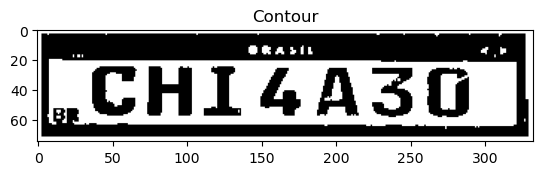

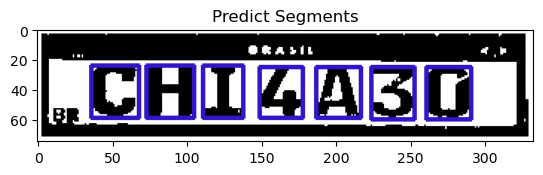

1/1 [==============================] - 0s 23ms/step
C
1/1 [==============================] - 0s 22ms/step
CH
1/1 [==============================] - 0s 22ms/step
CHI
1/1 [==============================] - 0s 23ms/step
CHI4
1/1 [==============================] - 0s 22ms/step
CHI4A
1/1 [==============================] - 0s 22ms/step
CHI4A3
1/1 [==============================] - 0s 23ms/step
CHI4A30


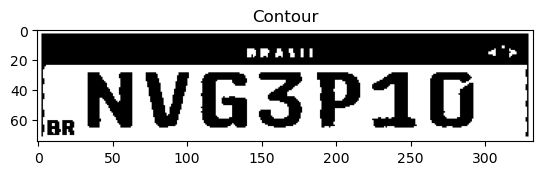

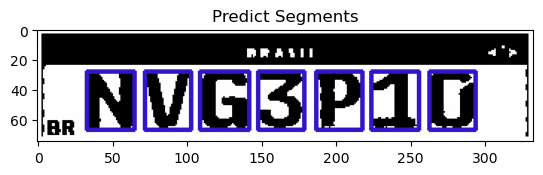

1/1 [==============================] - 0s 28ms/step
N
1/1 [==============================] - 0s 23ms/step
NV
1/1 [==============================] - 0s 24ms/step
NVG
1/1 [==============================] - 0s 24ms/step
NVG3
1/1 [==============================] - 0s 25ms/step
NVG3P
1/1 [==============================] - 0s 24ms/step
NVG3P1
1/1 [==============================] - 0s 23ms/step
NVG3P10


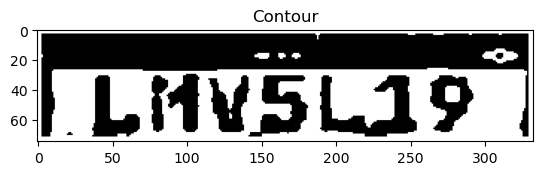

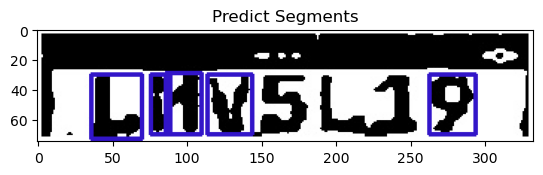

1/1 [==============================] - 0s 24ms/step
L
1/1 [==============================] - 0s 22ms/step
LF
1/1 [==============================] - 0s 26ms/step
LF1
1/1 [==============================] - 0s 24ms/step
LF1V
1/1 [==============================] - 0s 23ms/step
LF1V9


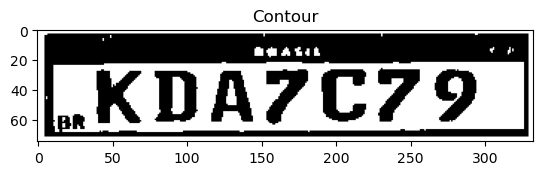

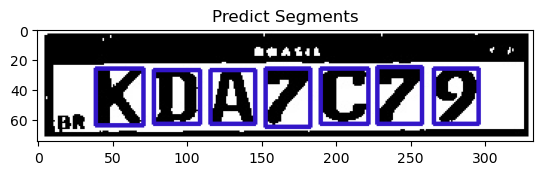

1/1 [==============================] - 0s 25ms/step
K
1/1 [==============================] - 0s 22ms/step
KD
1/1 [==============================] - 0s 22ms/step
KDA
1/1 [==============================] - 0s 22ms/step
KDA7
1/1 [==============================] - 0s 22ms/step
KDA7C
1/1 [==============================] - 0s 22ms/step
KDA7C7
1/1 [==============================] - 0s 23ms/step
KDA7C79


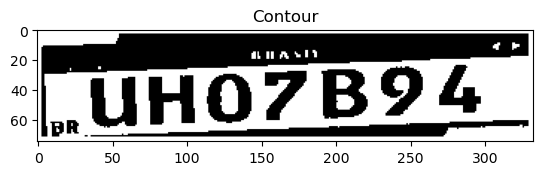

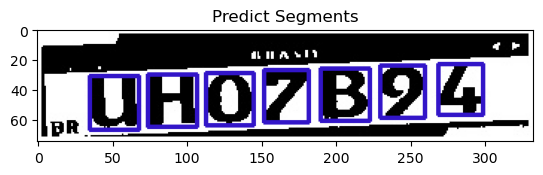

1/1 [==============================] - 0s 23ms/step
U
1/1 [==============================] - 0s 22ms/step
UH
1/1 [==============================] - 0s 23ms/step
UH0
1/1 [==============================] - 0s 23ms/step
UH07
1/1 [==============================] - 0s 25ms/step
UH07B
1/1 [==============================] - 0s 24ms/step
UH07B9
1/1 [==============================] - 0s 24ms/step
UH07B94


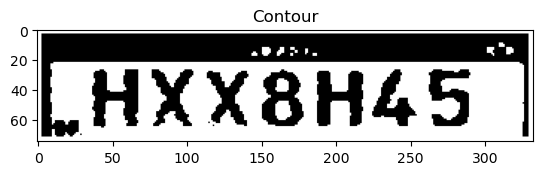

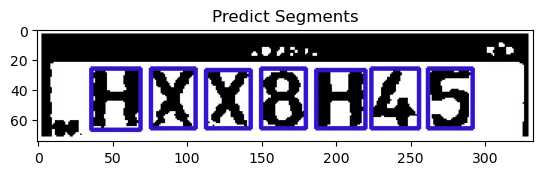

1/1 [==============================] - 0s 23ms/step
H
1/1 [==============================] - 0s 22ms/step
HX
1/1 [==============================] - 0s 22ms/step
HXX
1/1 [==============================] - 0s 21ms/step
HXX8
1/1 [==============================] - 0s 24ms/step
HXX8H
1/1 [==============================] - 0s 21ms/step
HXX8H4
1/1 [==============================] - 0s 24ms/step
HXX8H45


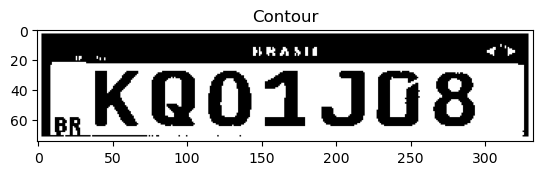

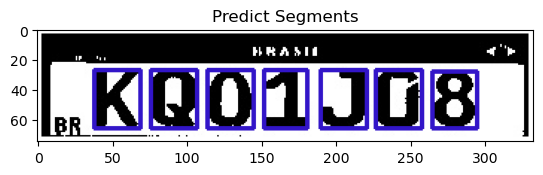

1/1 [==============================] - 0s 23ms/step
K
1/1 [==============================] - 0s 22ms/step
KQ
1/1 [==============================] - 0s 22ms/step
KQ0
1/1 [==============================] - 0s 22ms/step
KQ01
1/1 [==============================] - 0s 25ms/step
KQ01J
1/1 [==============================] - 0s 25ms/step
KQ01J0
1/1 [==============================] - 0s 27ms/step
KQ01J08


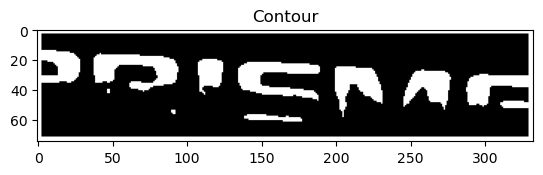

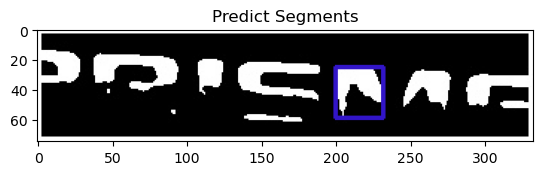

1/1 [==============================] - 0s 26ms/step
N


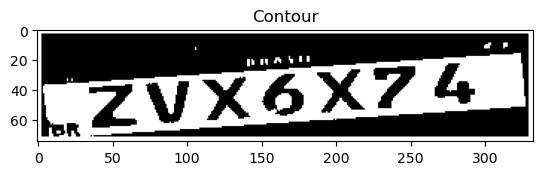

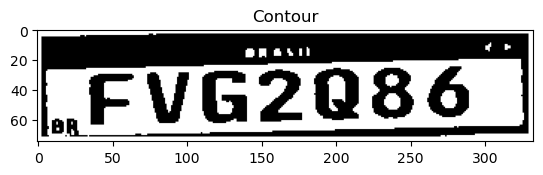

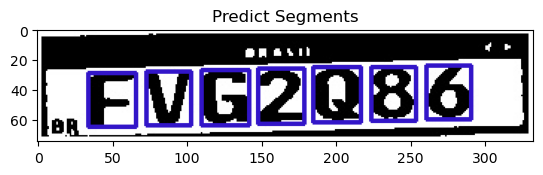

1/1 [==============================] - 0s 25ms/step
F
1/1 [==============================] - 0s 22ms/step
FV
1/1 [==============================] - 0s 22ms/step
FVG
1/1 [==============================] - 0s 21ms/step
FVG2
1/1 [==============================] - 0s 22ms/step
FVG2Q
1/1 [==============================] - 0s 22ms/step
FVG2Q8
1/1 [==============================] - 0s 24ms/step
FVG2Q86


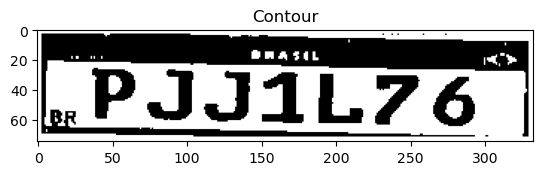

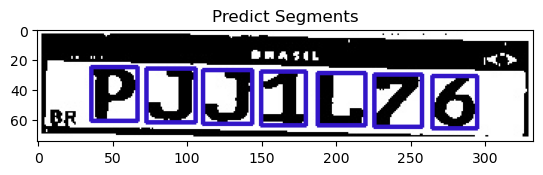

1/1 [==============================] - 0s 23ms/step
P
1/1 [==============================] - 0s 21ms/step
PJ
1/1 [==============================] - 0s 23ms/step
PJJ
1/1 [==============================] - 0s 22ms/step
PJJ1
1/1 [==============================] - 0s 23ms/step
PJJ1L
1/1 [==============================] - 0s 24ms/step
PJJ1L7
1/1 [==============================] - 0s 25ms/step
PJJ1L76


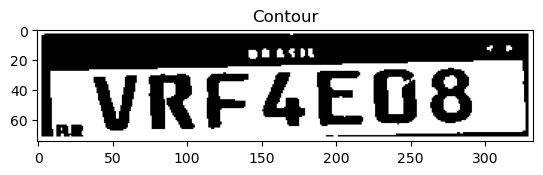

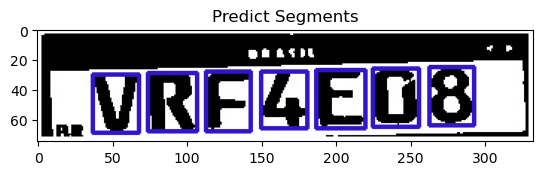

1/1 [==============================] - 0s 25ms/step
V
1/1 [==============================] - 0s 24ms/step
VR
1/1 [==============================] - 0s 24ms/step
VRF
1/1 [==============================] - 0s 23ms/step
VRF4
1/1 [==============================] - 0s 21ms/step
VRF4E
1/1 [==============================] - 0s 22ms/step
VRF4E0
1/1 [==============================] - 0s 24ms/step
VRF4E08


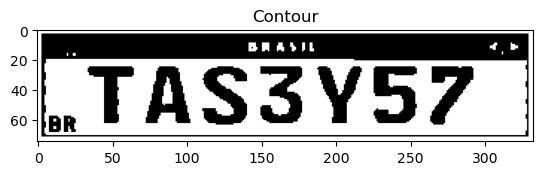

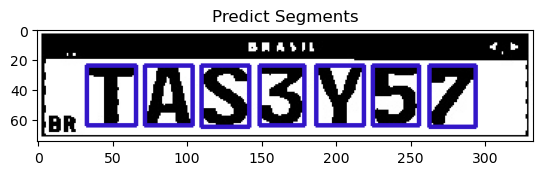

1/1 [==============================] - 0s 23ms/step
T
1/1 [==============================] - 0s 22ms/step
TA
1/1 [==============================] - 0s 23ms/step
TAS
1/1 [==============================] - 0s 24ms/step
TAS3
1/1 [==============================] - 0s 22ms/step
TAS3Y
1/1 [==============================] - 0s 23ms/step
TAS3Y5
1/1 [==============================] - 0s 24ms/step
TAS3Y57


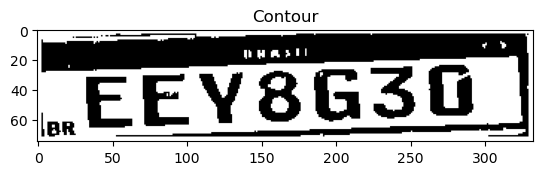

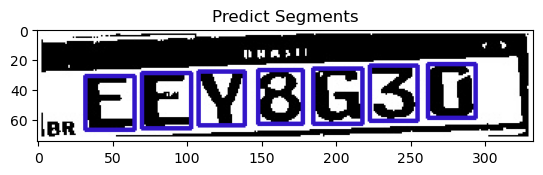

1/1 [==============================] - 0s 23ms/step
E
1/1 [==============================] - 0s 21ms/step
EE
1/1 [==============================] - 0s 22ms/step
EEY
1/1 [==============================] - 0s 23ms/step
EEY8
1/1 [==============================] - 0s 25ms/step
EEY8G
1/1 [==============================] - 0s 25ms/step
EEY8G3
1/1 [==============================] - 0s 23ms/step
EEY8G3G


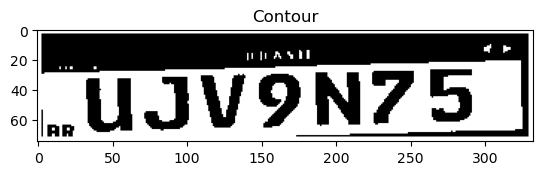

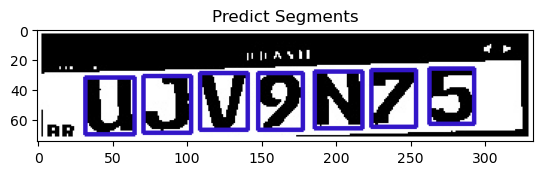

1/1 [==============================] - 0s 25ms/step
U
1/1 [==============================] - 0s 21ms/step
UJ
1/1 [==============================] - 0s 21ms/step
UJV
1/1 [==============================] - 0s 23ms/step
UJV9
1/1 [==============================] - 0s 23ms/step
UJV9N
1/1 [==============================] - 0s 22ms/step
UJV9N7
1/1 [==============================] - 0s 24ms/step
UJV9N75


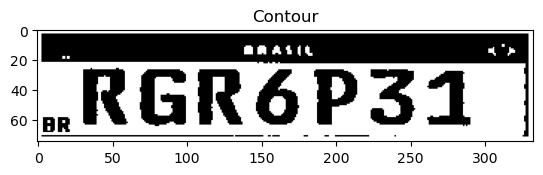

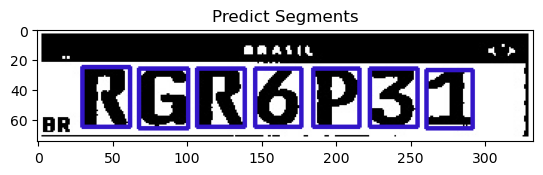

1/1 [==============================] - 0s 24ms/step
R
1/1 [==============================] - 0s 24ms/step
RG
1/1 [==============================] - 0s 24ms/step
RGR
1/1 [==============================] - 0s 22ms/step
RGR6
1/1 [==============================] - 0s 22ms/step
RGR6P
1/1 [==============================] - 0s 24ms/step
RGR6P3
1/1 [==============================] - 0s 25ms/step
RGR6P31


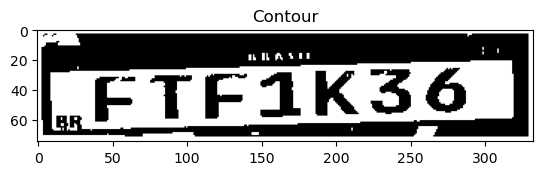

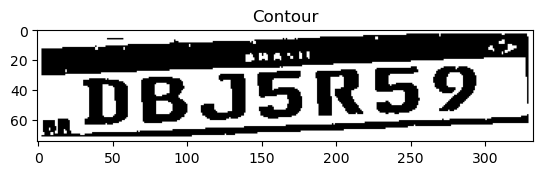

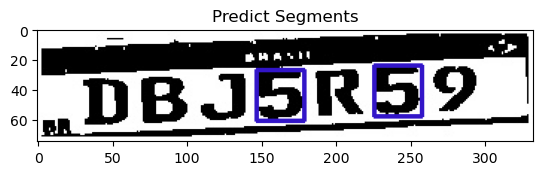

1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 24ms/step
55


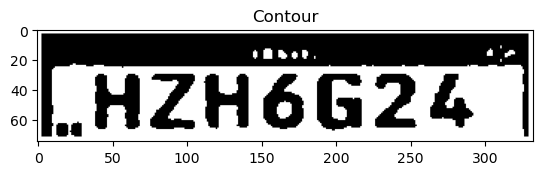

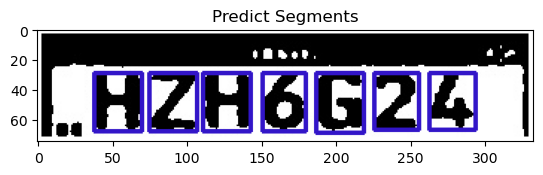

1/1 [==============================] - 0s 24ms/step
H
1/1 [==============================] - 0s 23ms/step
HZ
1/1 [==============================] - 0s 22ms/step
HZH
1/1 [==============================] - 0s 25ms/step
HZH6
1/1 [==============================] - 0s 23ms/step
HZH6G
1/1 [==============================] - 0s 22ms/step
HZH6G2
1/1 [==============================] - 0s 33ms/step
HZH6G24


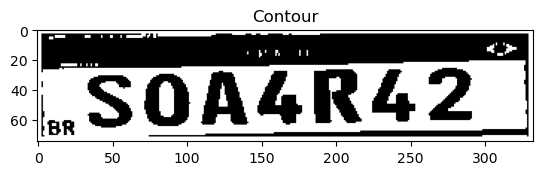

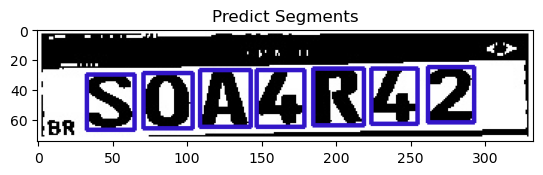

1/1 [==============================] - 0s 25ms/step
S
1/1 [==============================] - 0s 22ms/step
S0
1/1 [==============================] - 0s 22ms/step
S0A
1/1 [==============================] - 0s 23ms/step
S0A4
1/1 [==============================] - 0s 22ms/step
S0A4R
1/1 [==============================] - 0s 25ms/step
S0A4R4
1/1 [==============================] - 0s 25ms/step
S0A4R42


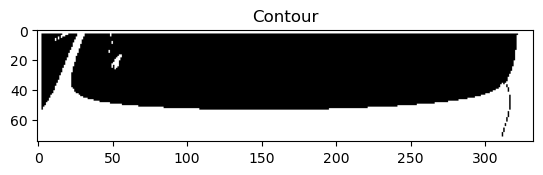

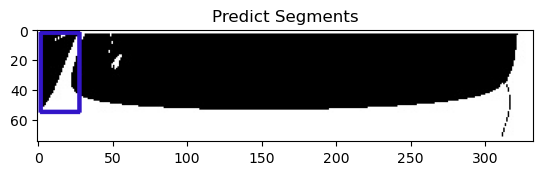

1/1 [==============================] - 0s 23ms/step
V


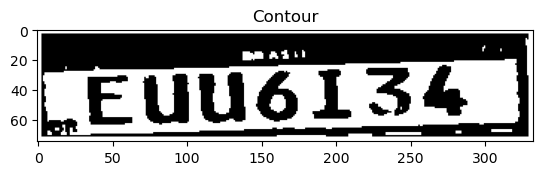

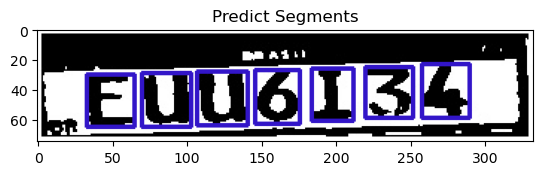

1/1 [==============================] - 0s 22ms/step
E
1/1 [==============================] - 0s 24ms/step
EU
1/1 [==============================] - 0s 22ms/step
EUU
1/1 [==============================] - 0s 24ms/step
EUU6
1/1 [==============================] - 0s 23ms/step
EUU6I
1/1 [==============================] - 0s 24ms/step
EUU6I3
1/1 [==============================] - 0s 24ms/step
EUU6I34


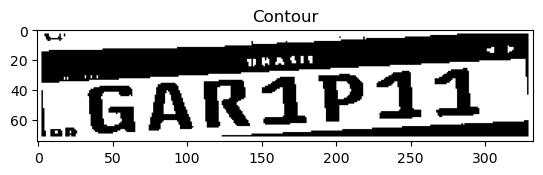

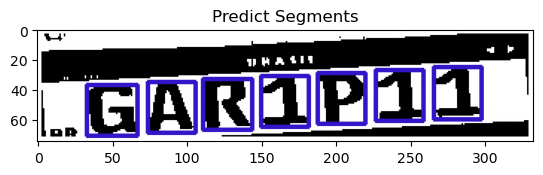

1/1 [==============================] - 0s 37ms/step
G
1/1 [==============================] - 0s 34ms/step
GA
1/1 [==============================] - 0s 36ms/step
GAR
1/1 [==============================] - 0s 35ms/step
GAR1
1/1 [==============================] - 0s 36ms/step
GAR1P
1/1 [==============================] - 0s 34ms/step
GAR1P1
1/1 [==============================] - 0s 39ms/step
GAR1P11


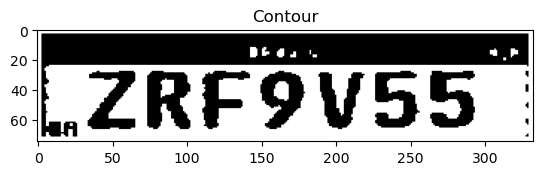

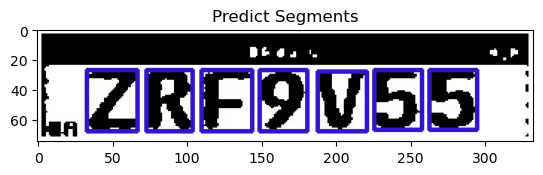

1/1 [==============================] - 0s 26ms/step
Z
1/1 [==============================] - 0s 24ms/step
ZR
1/1 [==============================] - 0s 22ms/step
ZRF
1/1 [==============================] - 0s 23ms/step
ZRF9
1/1 [==============================] - 0s 24ms/step
ZRF9V
1/1 [==============================] - 0s 22ms/step
ZRF9V5
1/1 [==============================] - 0s 22ms/step
ZRF9V55


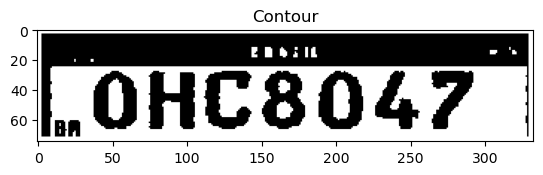

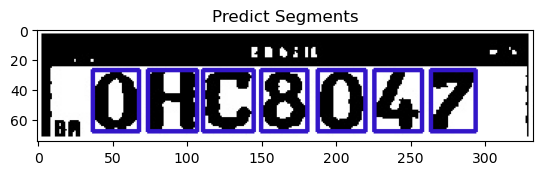

1/1 [==============================] - 0s 27ms/step
0
1/1 [==============================] - 0s 24ms/step
0H
1/1 [==============================] - 0s 23ms/step
0HC
1/1 [==============================] - 0s 25ms/step
0HC8
1/1 [==============================] - 0s 26ms/step
0HC80
1/1 [==============================] - 0s 25ms/step
0HC804
1/1 [==============================] - 0s 27ms/step
0HC8047


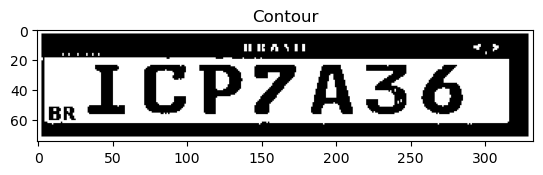

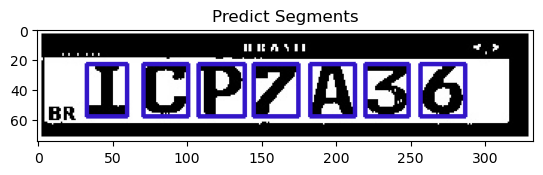

1/1 [==============================] - 0s 24ms/step
I
1/1 [==============================] - 0s 24ms/step
IC
1/1 [==============================] - 0s 23ms/step
ICP
1/1 [==============================] - 0s 25ms/step
ICP7
1/1 [==============================] - 0s 25ms/step
ICP7A
1/1 [==============================] - 0s 24ms/step
ICP7A3
1/1 [==============================] - 0s 28ms/step
ICP7A36


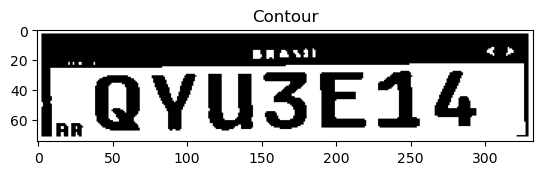

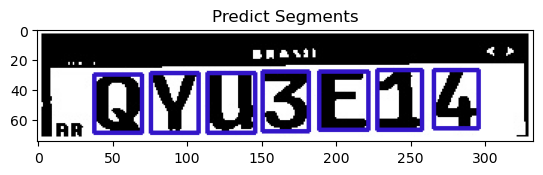

1/1 [==============================] - 0s 24ms/step
Q
1/1 [==============================] - 0s 22ms/step
QY
1/1 [==============================] - 0s 21ms/step
QYU
1/1 [==============================] - 0s 22ms/step
QYU3
1/1 [==============================] - 0s 23ms/step
QYU3E
1/1 [==============================] - 0s 21ms/step
QYU3E1
1/1 [==============================] - 0s 25ms/step
QYU3E14


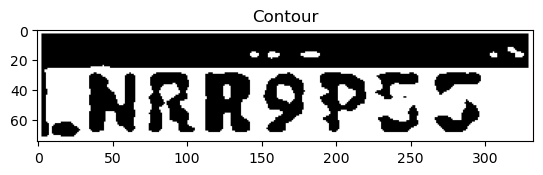

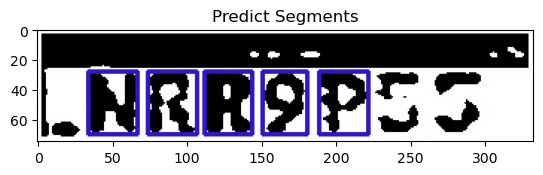

1/1 [==============================] - 0s 24ms/step
N
1/1 [==============================] - 0s 23ms/step
NR
1/1 [==============================] - 0s 22ms/step
NRR
1/1 [==============================] - 0s 22ms/step
NRR9
1/1 [==============================] - 0s 23ms/step
NRR9P


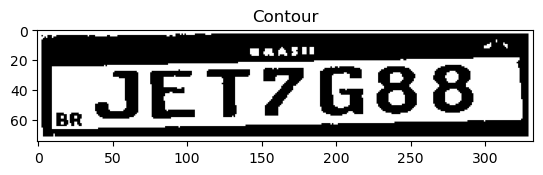

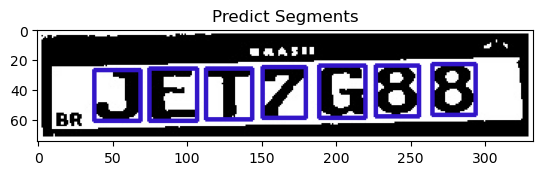

1/1 [==============================] - 0s 23ms/step
J
1/1 [==============================] - 0s 32ms/step
JE
1/1 [==============================] - 0s 23ms/step
JET
1/1 [==============================] - 0s 53ms/step
JET7
1/1 [==============================] - 0s 25ms/step
JET7G
1/1 [==============================] - 0s 24ms/step
JET7G8
1/1 [==============================] - 0s 23ms/step
JET7G88


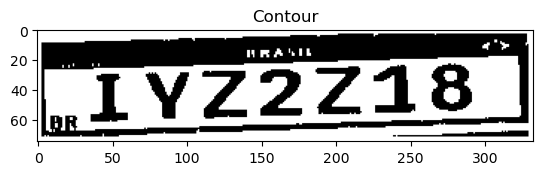

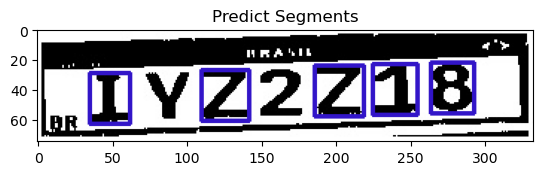

1/1 [==============================] - 0s 24ms/step
I
1/1 [==============================] - 0s 23ms/step
IZ
1/1 [==============================] - 0s 22ms/step
IZZ
1/1 [==============================] - 0s 26ms/step
IZZ1
1/1 [==============================] - 0s 23ms/step
IZZ18


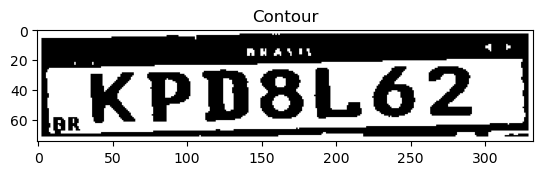

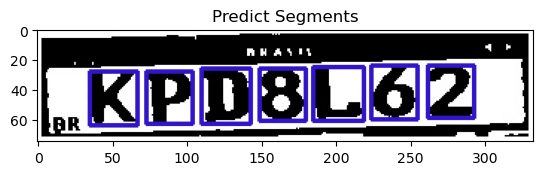

1/1 [==============================] - 0s 25ms/step
K
1/1 [==============================] - 0s 23ms/step
KP
1/1 [==============================] - 0s 23ms/step
KPD
1/1 [==============================] - 0s 23ms/step
KPD8
1/1 [==============================] - 0s 23ms/step
KPD8L
1/1 [==============================] - 0s 22ms/step
KPD8L6
1/1 [==============================] - 0s 24ms/step
KPD8L62


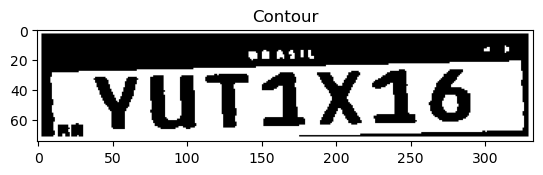

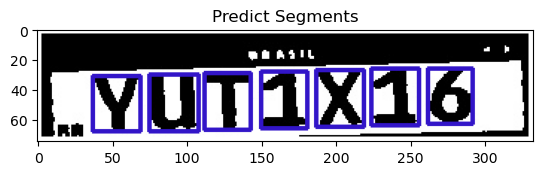

1/1 [==============================] - 0s 24ms/step
Y
1/1 [==============================] - 0s 22ms/step
YU
1/1 [==============================] - 0s 23ms/step
YUT
1/1 [==============================] - 0s 28ms/step
YUT1
1/1 [==============================] - 0s 25ms/step
YUT1X
1/1 [==============================] - 0s 24ms/step
YUT1X1
1/1 [==============================] - 0s 25ms/step
YUT1X16


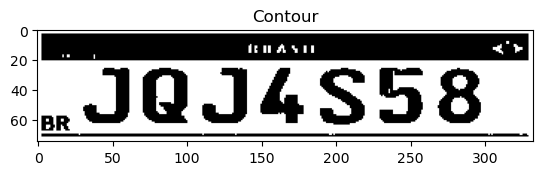

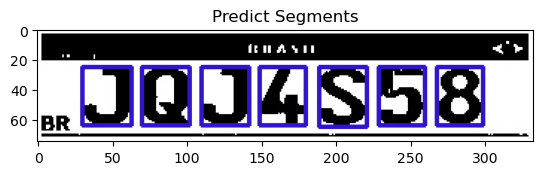

1/1 [==============================] - 0s 23ms/step
J
1/1 [==============================] - 0s 23ms/step
JQ
1/1 [==============================] - 0s 22ms/step
JQJ
1/1 [==============================] - 0s 23ms/step
JQJ4
1/1 [==============================] - 0s 23ms/step
JQJ4S
1/1 [==============================] - 0s 22ms/step
JQJ4S5
1/1 [==============================] - 0s 23ms/step
JQJ4S58


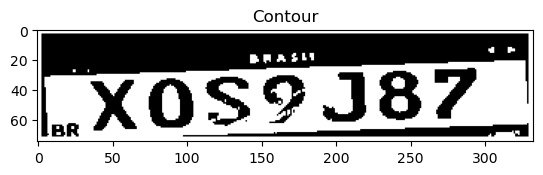

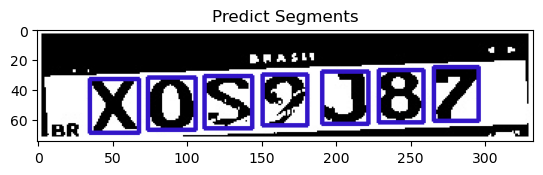

1/1 [==============================] - 0s 23ms/step
X
1/1 [==============================] - 0s 21ms/step
X0
1/1 [==============================] - 0s 23ms/step
X0S
1/1 [==============================] - 0s 24ms/step
X0SQ
1/1 [==============================] - 0s 22ms/step
X0SQJ
1/1 [==============================] - 0s 24ms/step
X0SQJ8
1/1 [==============================] - 0s 24ms/step
X0SQJ87


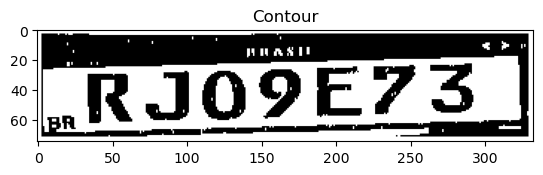

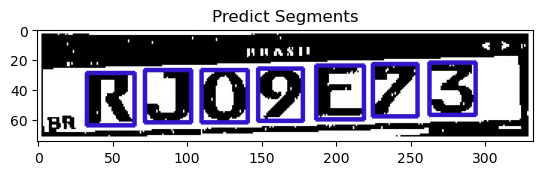

1/1 [==============================] - 0s 24ms/step
R
1/1 [==============================] - 0s 24ms/step
RJ
1/1 [==============================] - 0s 24ms/step
RJ0
1/1 [==============================] - 0s 24ms/step
RJ09
1/1 [==============================] - 0s 24ms/step
RJ09E
1/1 [==============================] - 0s 22ms/step
RJ09E7
1/1 [==============================] - 0s 23ms/step
RJ09E73


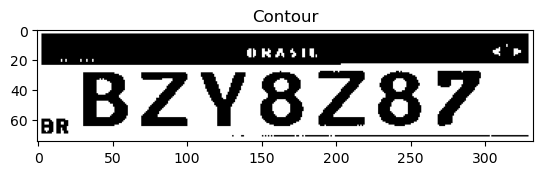

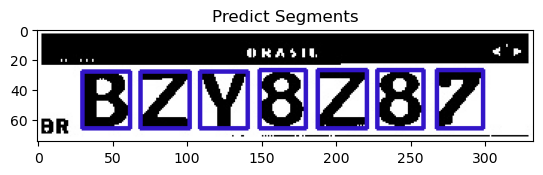

1/1 [==============================] - 0s 23ms/step
B
1/1 [==============================] - 0s 22ms/step
BZ
1/1 [==============================] - 0s 23ms/step
BZY
1/1 [==============================] - 0s 23ms/step
BZY8
1/1 [==============================] - 0s 22ms/step
BZY8Z
1/1 [==============================] - 0s 22ms/step
BZY8Z8
1/1 [==============================] - 0s 23ms/step
BZY8Z87


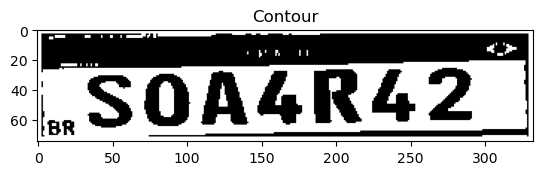

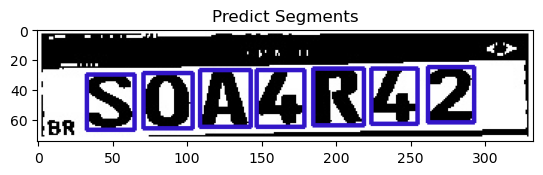

1/1 [==============================] - 0s 23ms/step
S
1/1 [==============================] - 0s 22ms/step
S0
1/1 [==============================] - 0s 23ms/step
S0A
1/1 [==============================] - 0s 25ms/step
S0A4
1/1 [==============================] - 0s 27ms/step
S0A4R
1/1 [==============================] - 0s 26ms/step
S0A4R4
1/1 [==============================] - 0s 23ms/step
S0A4R42


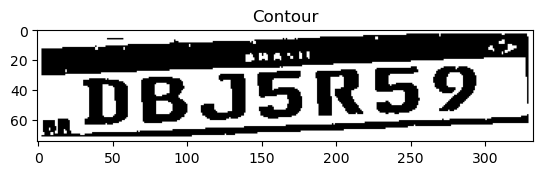

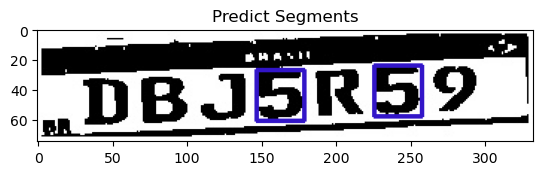

1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 23ms/step
55


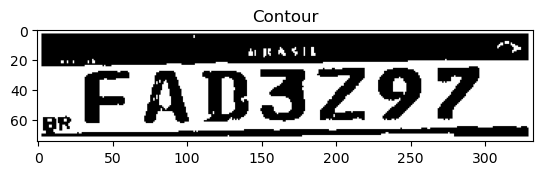

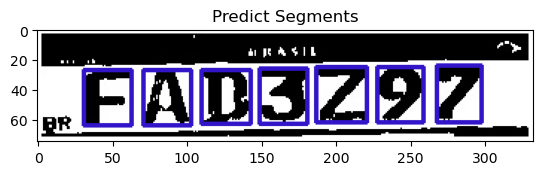

1/1 [==============================] - 0s 25ms/step
F
1/1 [==============================] - 0s 23ms/step
FA
1/1 [==============================] - 0s 59ms/step
FAB
1/1 [==============================] - 0s 24ms/step
FAB3
1/1 [==============================] - 0s 23ms/step
FAB3Z
1/1 [==============================] - 0s 21ms/step
FAB3Z9
1/1 [==============================] - 0s 23ms/step
FAB3Z97


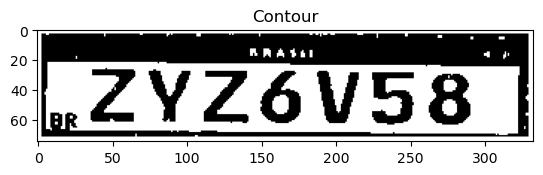

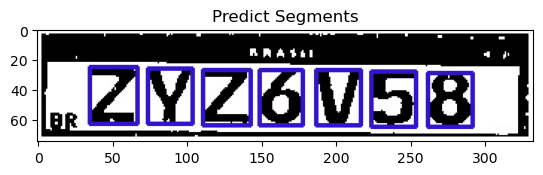

1/1 [==============================] - 0s 23ms/step
Z
1/1 [==============================] - 0s 22ms/step
ZY
1/1 [==============================] - 0s 23ms/step
ZYZ
1/1 [==============================] - 0s 22ms/step
ZYZ6
1/1 [==============================] - 0s 22ms/step
ZYZ6V
1/1 [==============================] - 0s 23ms/step
ZYZ6V5
1/1 [==============================] - 0s 23ms/step
ZYZ6V58


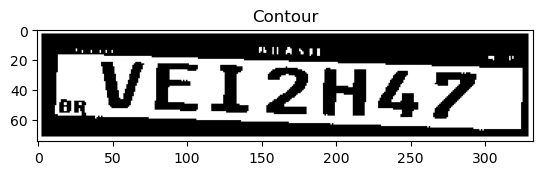

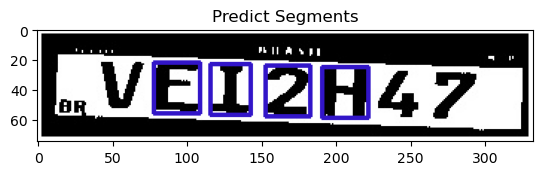

1/1 [==============================] - 0s 25ms/step
E
1/1 [==============================] - 0s 23ms/step
EI
1/1 [==============================] - 0s 22ms/step
EI2
1/1 [==============================] - 0s 24ms/step
EI2H


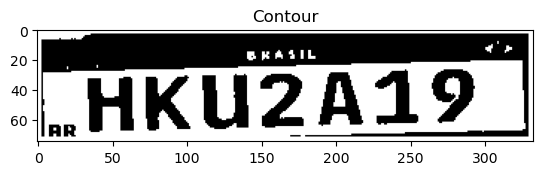

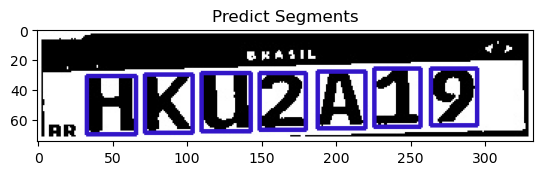

1/1 [==============================] - 0s 23ms/step
H
1/1 [==============================] - 0s 23ms/step
HK
1/1 [==============================] - 0s 23ms/step
HKU
1/1 [==============================] - 0s 24ms/step
HKU2
1/1 [==============================] - 0s 23ms/step
HKU2A
1/1 [==============================] - 0s 21ms/step
HKU2A1
1/1 [==============================] - 0s 23ms/step
HKU2A19


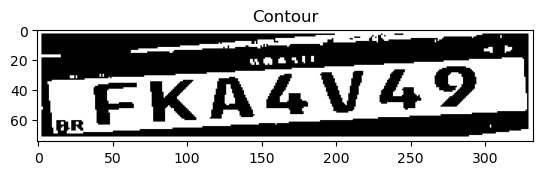

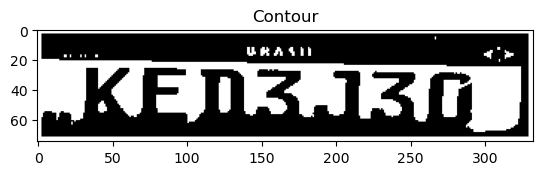

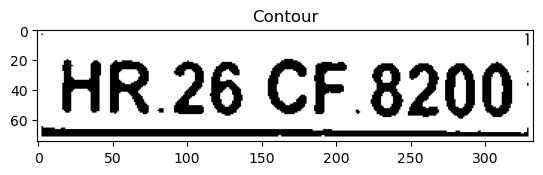

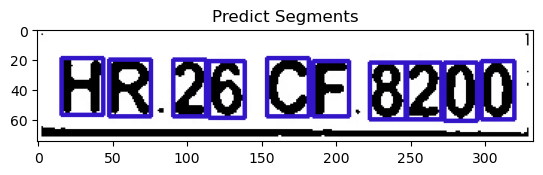

1/1 [==============================] - 0s 27ms/step
H
1/1 [==============================] - 0s 27ms/step
HR
1/1 [==============================] - 0s 28ms/step
HR2
1/1 [==============================] - 0s 29ms/step
HR26
1/1 [==============================] - 0s 27ms/step
HR26C
1/1 [==============================] - 0s 32ms/step
HR26CF
1/1 [==============================] - 0s 28ms/step
HR26CF8
1/1 [==============================] - 0s 26ms/step
HR26CF82
1/1 [==============================] - 0s 26ms/step
HR26CF820
1/1 [==============================] - 0s 28ms/step
HR26CF8200


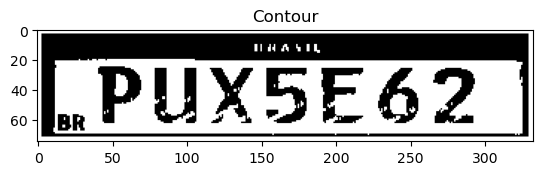

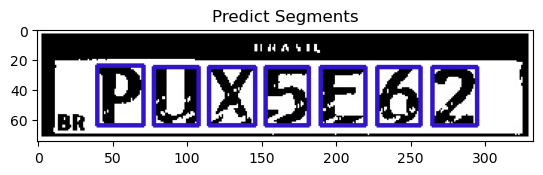

1/1 [==============================] - 0s 28ms/step
P
1/1 [==============================] - 0s 30ms/step
PU
1/1 [==============================] - 0s 26ms/step
PUX
1/1 [==============================] - 0s 27ms/step
PUX5
1/1 [==============================] - 0s 29ms/step
PUX5E
1/1 [==============================] - 0s 29ms/step
PUX5E6
1/1 [==============================] - 0s 27ms/step
PUX5E62


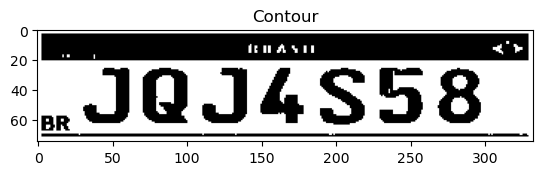

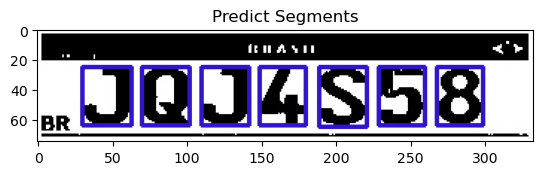

1/1 [==============================] - 0s 32ms/step
J
1/1 [==============================] - 0s 30ms/step
JQ
1/1 [==============================] - 0s 28ms/step
JQJ
1/1 [==============================] - 0s 27ms/step
JQJ4
1/1 [==============================] - 0s 28ms/step
JQJ4S
1/1 [==============================] - 0s 27ms/step
JQJ4S5
1/1 [==============================] - 0s 25ms/step
JQJ4S58


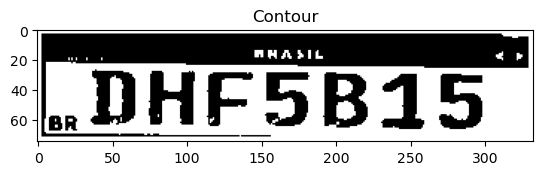

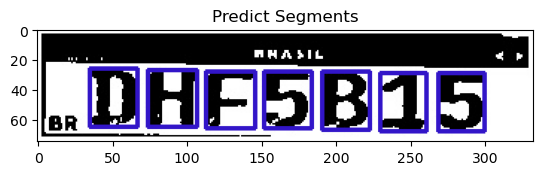

1/1 [==============================] - 0s 26ms/step
D
1/1 [==============================] - 0s 25ms/step
DH
1/1 [==============================] - 0s 27ms/step
DHF
1/1 [==============================] - 0s 24ms/step
DHF5
1/1 [==============================] - 0s 28ms/step
DHF5B
1/1 [==============================] - 0s 26ms/step
DHF5B1
1/1 [==============================] - 0s 29ms/step
DHF5B15


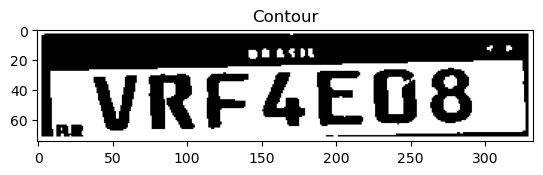

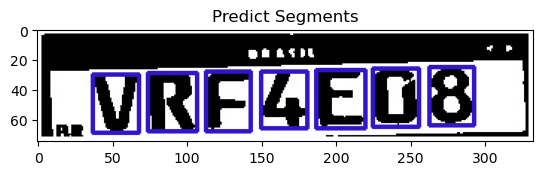

1/1 [==============================] - 0s 26ms/step
V
1/1 [==============================] - 0s 28ms/step
VR
1/1 [==============================] - 0s 28ms/step
VRF
1/1 [==============================] - 0s 28ms/step
VRF4
1/1 [==============================] - 0s 67ms/step
VRF4E
1/1 [==============================] - 0s 52ms/step
VRF4E0
1/1 [==============================] - 0s 25ms/step
VRF4E08


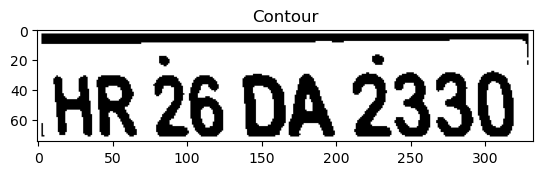

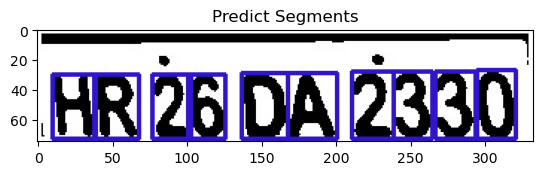

1/1 [==============================] - 0s 26ms/step
H
1/1 [==============================] - 0s 24ms/step
HR
1/1 [==============================] - 0s 24ms/step
HR2
1/1 [==============================] - 0s 24ms/step
HR26
1/1 [==============================] - 0s 25ms/step
HR26D
1/1 [==============================] - 0s 27ms/step
HR26DA
1/1 [==============================] - 0s 27ms/step
HR26DA2
1/1 [==============================] - 0s 25ms/step
HR26DA23
1/1 [==============================] - 0s 25ms/step
HR26DA233
1/1 [==============================] - 0s 27ms/step
HR26DA2330


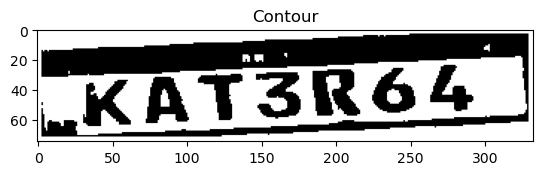

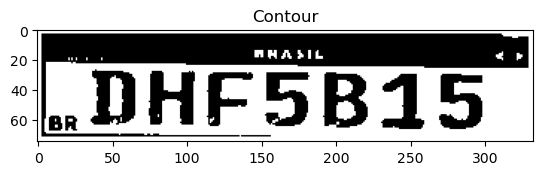

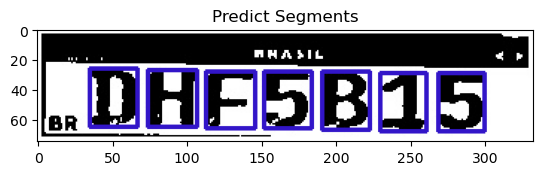

1/1 [==============================] - 0s 24ms/step
D
1/1 [==============================] - 0s 22ms/step
DH
1/1 [==============================] - 0s 22ms/step
DHF
1/1 [==============================] - 0s 24ms/step
DHF5
1/1 [==============================] - 0s 23ms/step
DHF5B
1/1 [==============================] - 0s 27ms/step
DHF5B1
1/1 [==============================] - 0s 24ms/step
DHF5B15


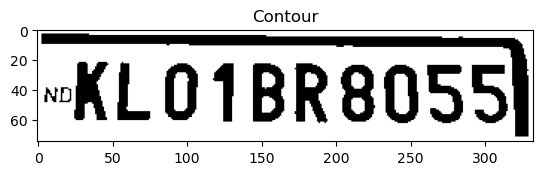

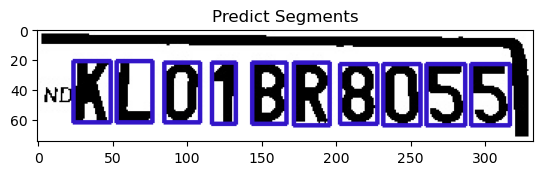

1/1 [==============================] - 0s 26ms/step
K
1/1 [==============================] - 0s 24ms/step
KL
1/1 [==============================] - 0s 23ms/step
KL0
1/1 [==============================] - 0s 25ms/step
KL01
1/1 [==============================] - 0s 23ms/step
KL01B
1/1 [==============================] - 0s 24ms/step
KL01BR
1/1 [==============================] - 0s 26ms/step
KL01BR8
1/1 [==============================] - 0s 23ms/step
KL01BR80
1/1 [==============================] - 0s 23ms/step
KL01BR805
1/1 [==============================] - 0s 24ms/step
KL01BR8055


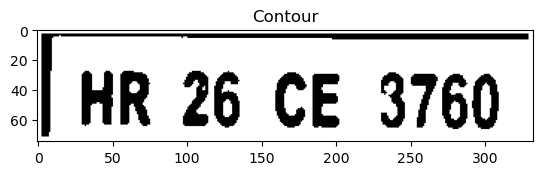

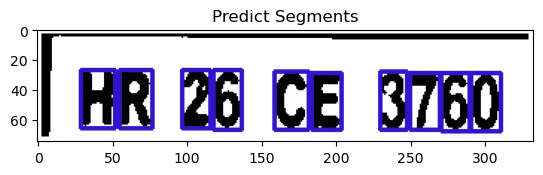

1/1 [==============================] - 0s 24ms/step
H
1/1 [==============================] - 0s 25ms/step
HR
1/1 [==============================] - 0s 53ms/step
HR2
1/1 [==============================] - 0s 39ms/step
HR26
1/1 [==============================] - 0s 37ms/step
HR26C
1/1 [==============================] - 0s 36ms/step
HR26CE
1/1 [==============================] - 0s 39ms/step
HR26CE3
1/1 [==============================] - 0s 35ms/step
HR26CE37
1/1 [==============================] - 0s 47ms/step
HR26CE376
1/1 [==============================] - 0s 35ms/step
HR26CE3760


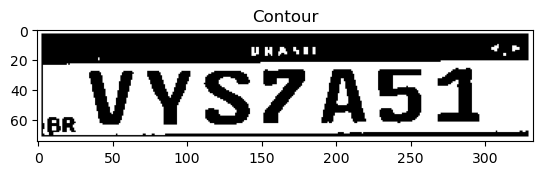

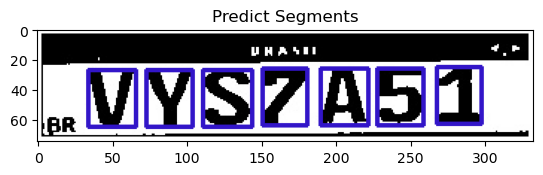

1/1 [==============================] - 0s 27ms/step
V
1/1 [==============================] - 0s 26ms/step
VY
1/1 [==============================] - 0s 24ms/step
VYS
1/1 [==============================] - 0s 24ms/step
VYS7
1/1 [==============================] - 0s 23ms/step
VYS7A
1/1 [==============================] - 0s 22ms/step
VYS7A5
1/1 [==============================] - 0s 22ms/step
VYS7A51


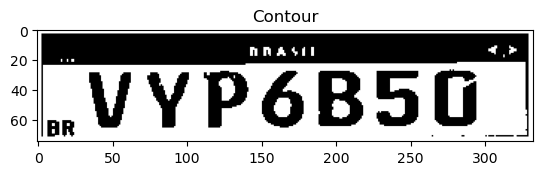

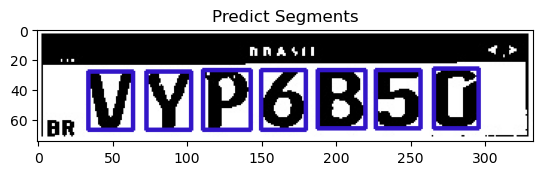

1/1 [==============================] - 0s 23ms/step
V
1/1 [==============================] - 0s 22ms/step
VY
1/1 [==============================] - 0s 22ms/step
VYP
1/1 [==============================] - 0s 22ms/step
VYP6
1/1 [==============================] - 0s 23ms/step
VYP6B
1/1 [==============================] - 0s 22ms/step
VYP6B5
1/1 [==============================] - 0s 25ms/step
VYP6B5G


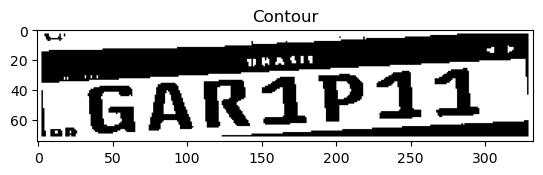

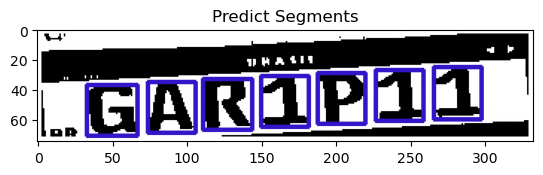

1/1 [==============================] - 0s 25ms/step
G
1/1 [==============================] - 0s 23ms/step
GA
1/1 [==============================] - 0s 24ms/step
GAR
1/1 [==============================] - 0s 23ms/step
GAR1
1/1 [==============================] - 0s 22ms/step
GAR1P
1/1 [==============================] - 0s 23ms/step
GAR1P1
1/1 [==============================] - 0s 23ms/step
GAR1P11


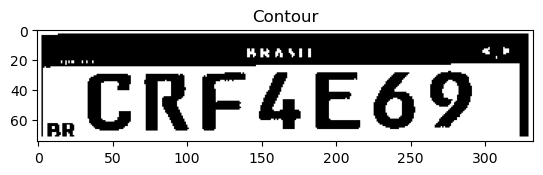

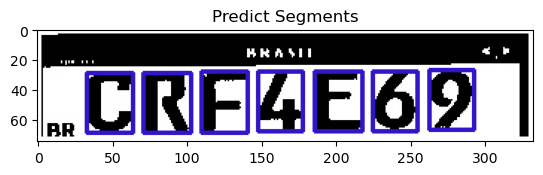

1/1 [==============================] - 0s 23ms/step
C
1/1 [==============================] - 0s 22ms/step
CR
1/1 [==============================] - 0s 24ms/step
CRF
1/1 [==============================] - 0s 23ms/step
CRF4
1/1 [==============================] - 0s 23ms/step
CRF4E
1/1 [==============================] - 0s 49ms/step
CRF4E6
1/1 [==============================] - 0s 22ms/step
CRF4E69


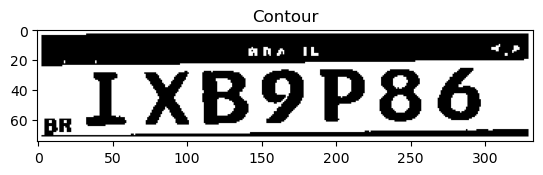

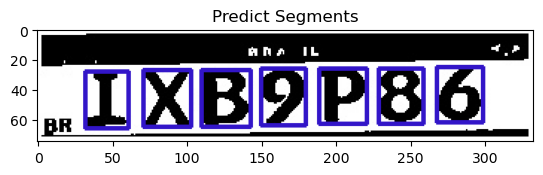

1/1 [==============================] - 0s 24ms/step
I
1/1 [==============================] - 0s 23ms/step
IX
1/1 [==============================] - 0s 24ms/step
IXB
1/1 [==============================] - 0s 24ms/step
IXB9
1/1 [==============================] - 0s 25ms/step
IXB9P
1/1 [==============================] - 0s 23ms/step
IXB9P8
1/1 [==============================] - 0s 23ms/step
IXB9P86


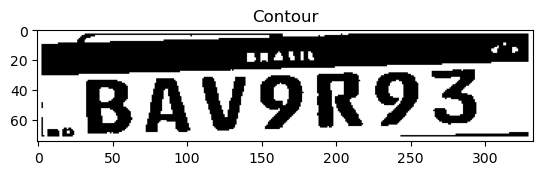

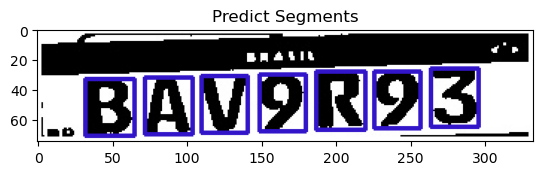

1/1 [==============================] - 0s 23ms/step
B
1/1 [==============================] - 0s 23ms/step
BA
1/1 [==============================] - 0s 22ms/step
BAV
1/1 [==============================] - 0s 24ms/step
BAV9
1/1 [==============================] - 0s 21ms/step
BAV9R
1/1 [==============================] - 0s 22ms/step
BAV9R9
1/1 [==============================] - 0s 21ms/step
BAV9R93


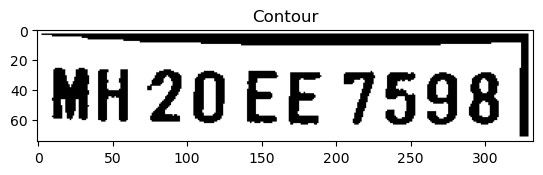

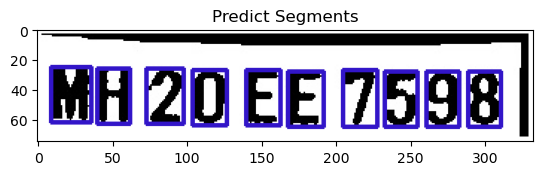

1/1 [==============================] - 0s 24ms/step
M
1/1 [==============================] - 0s 23ms/step
MH
1/1 [==============================] - 0s 22ms/step
MH2
1/1 [==============================] - 0s 22ms/step
MH20
1/1 [==============================] - 0s 23ms/step
MH20E
1/1 [==============================] - 0s 25ms/step
MH20EE
1/1 [==============================] - 0s 25ms/step
MH20EE7
1/1 [==============================] - 0s 25ms/step
MH20EE75
1/1 [==============================] - 0s 27ms/step
MH20EE759
1/1 [==============================] - 0s 23ms/step
MH20EE7598


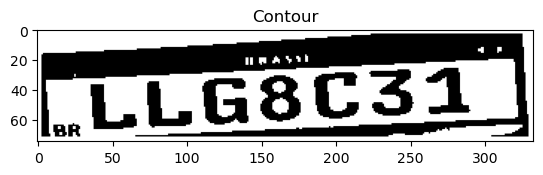

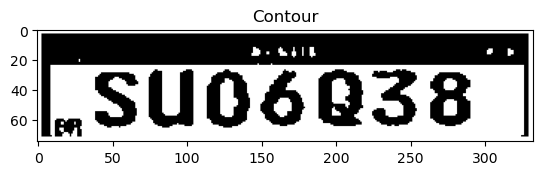

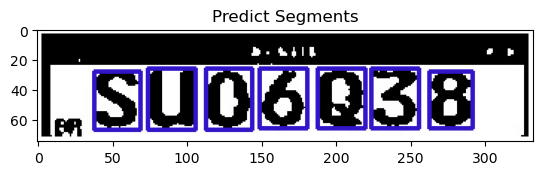

1/1 [==============================] - 0s 23ms/step
S
1/1 [==============================] - 0s 22ms/step
SU
1/1 [==============================] - 0s 22ms/step
SU0
1/1 [==============================] - 0s 22ms/step
SU06
1/1 [==============================] - 0s 24ms/step
SU06Q
1/1 [==============================] - 0s 24ms/step
SU06Q3
1/1 [==============================] - 0s 26ms/step
SU06Q38


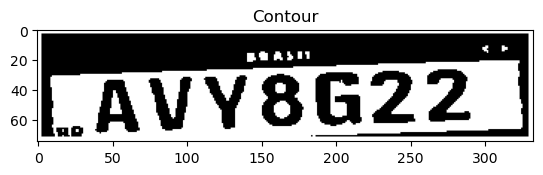

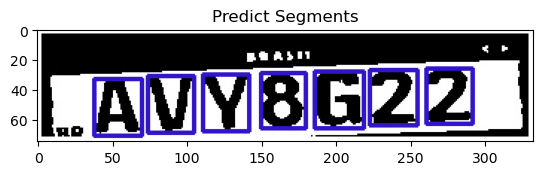

1/1 [==============================] - 0s 26ms/step
A
1/1 [==============================] - 0s 24ms/step
AV
1/1 [==============================] - 0s 23ms/step
AVY
1/1 [==============================] - 0s 22ms/step
AVY8
1/1 [==============================] - 0s 23ms/step
AVY8G
1/1 [==============================] - 0s 23ms/step
AVY8G2
1/1 [==============================] - 0s 24ms/step
AVY8G22


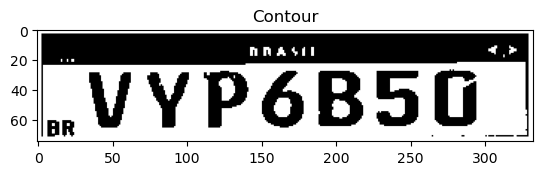

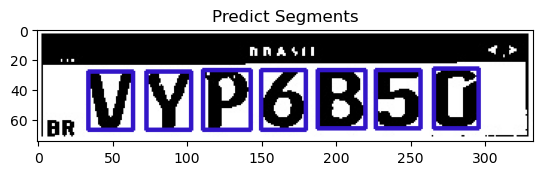

1/1 [==============================] - 0s 23ms/step
V
1/1 [==============================] - 0s 22ms/step
VY
1/1 [==============================] - 0s 22ms/step
VYP
1/1 [==============================] - 0s 23ms/step
VYP6
1/1 [==============================] - 0s 22ms/step
VYP6B
1/1 [==============================] - 0s 23ms/step
VYP6B5
1/1 [==============================] - 0s 24ms/step
VYP6B5G


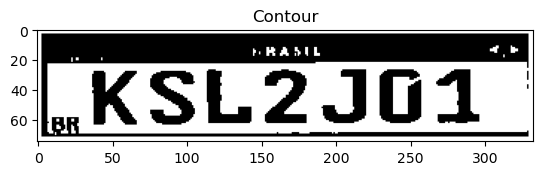

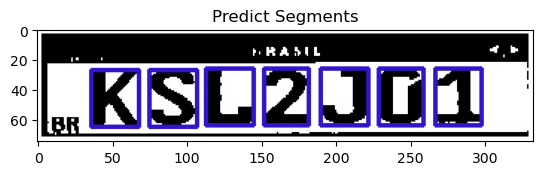

1/1 [==============================] - 0s 23ms/step
K
1/1 [==============================] - 0s 24ms/step
KS
1/1 [==============================] - 0s 23ms/step
KSL
1/1 [==============================] - 0s 26ms/step
KSL2
1/1 [==============================] - 0s 24ms/step
KSL2J
1/1 [==============================] - 0s 23ms/step
KSL2JG
1/1 [==============================] - 0s 23ms/step
KSL2JG1


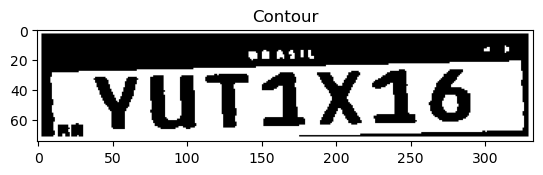

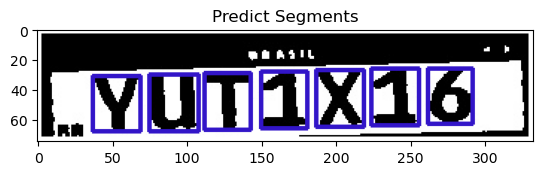

1/1 [==============================] - 0s 23ms/step
Y
1/1 [==============================] - 0s 23ms/step
YU
1/1 [==============================] - 0s 22ms/step
YUT
1/1 [==============================] - 0s 23ms/step
YUT1
1/1 [==============================] - 0s 23ms/step
YUT1X
1/1 [==============================] - 0s 23ms/step
YUT1X1
1/1 [==============================] - 0s 22ms/step
YUT1X16


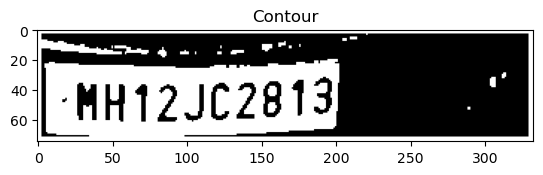

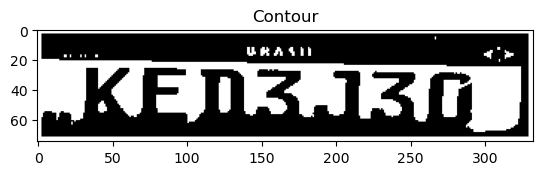

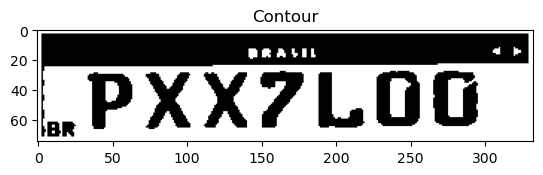

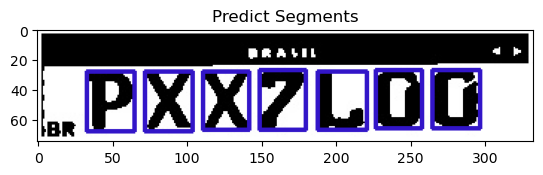

1/1 [==============================] - 0s 23ms/step
P
1/1 [==============================] - 0s 21ms/step
PX
1/1 [==============================] - 0s 22ms/step
PXX
1/1 [==============================] - 0s 22ms/step
PXX7
1/1 [==============================] - 0s 24ms/step
PXX7L
1/1 [==============================] - 0s 24ms/step
PXX7L0
1/1 [==============================] - 0s 24ms/step
PXX7L0G


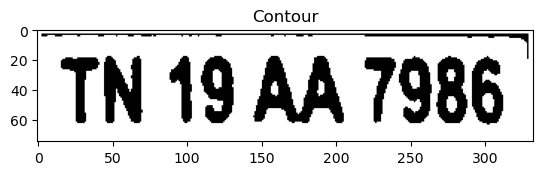

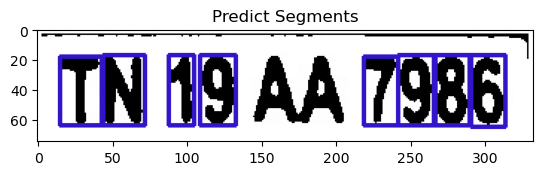

1/1 [==============================] - 0s 24ms/step
T
1/1 [==============================] - 0s 22ms/step
TN
1/1 [==============================] - 0s 22ms/step
TN1
1/1 [==============================] - 0s 26ms/step
TN19
1/1 [==============================] - 0s 21ms/step
TN197
1/1 [==============================] - 0s 23ms/step
TN1979
1/1 [==============================] - 0s 23ms/step
TN19798
1/1 [==============================] - 0s 22ms/step
TN197986


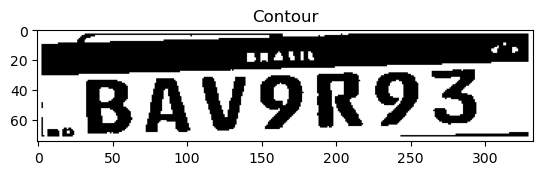

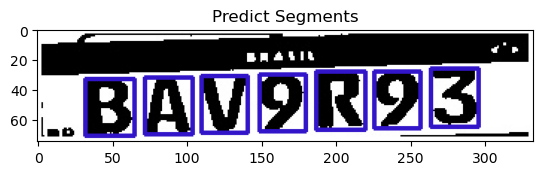

1/1 [==============================] - 0s 25ms/step
B
1/1 [==============================] - 0s 23ms/step
BA
1/1 [==============================] - 0s 22ms/step
BAV
1/1 [==============================] - 0s 22ms/step
BAV9
1/1 [==============================] - 0s 23ms/step
BAV9R
1/1 [==============================] - 0s 23ms/step
BAV9R9
1/1 [==============================] - 0s 27ms/step
BAV9R93


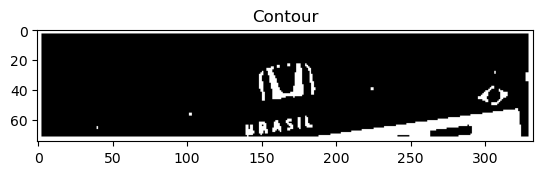

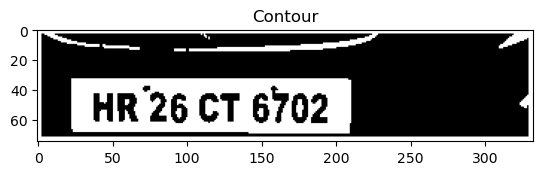

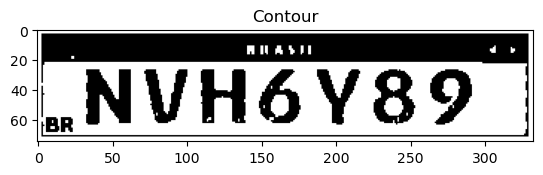

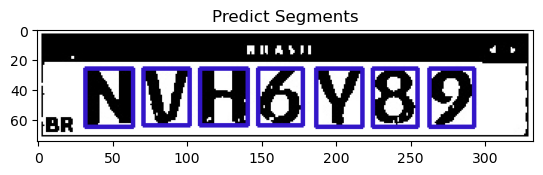

1/1 [==============================] - 0s 25ms/step
N
1/1 [==============================] - 0s 23ms/step
NU
1/1 [==============================] - 0s 22ms/step
NUH
1/1 [==============================] - 0s 25ms/step
NUH6
1/1 [==============================] - 0s 26ms/step
NUH6Y
1/1 [==============================] - 0s 22ms/step
NUH6Y8
1/1 [==============================] - 0s 23ms/step
NUH6Y89


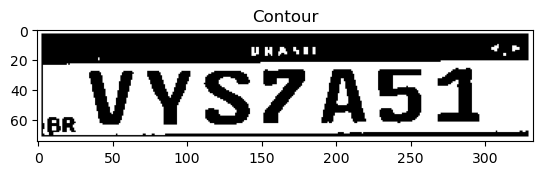

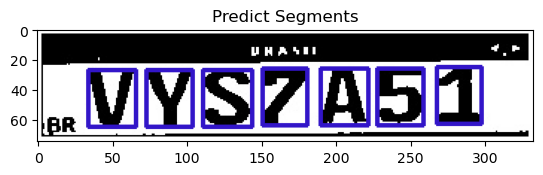

1/1 [==============================] - 0s 23ms/step
V
1/1 [==============================] - 0s 21ms/step
VY
1/1 [==============================] - 0s 21ms/step
VYS
1/1 [==============================] - 0s 21ms/step
VYS7
1/1 [==============================] - 0s 24ms/step
VYS7A
1/1 [==============================] - 0s 23ms/step
VYS7A5
1/1 [==============================] - 0s 23ms/step
VYS7A51


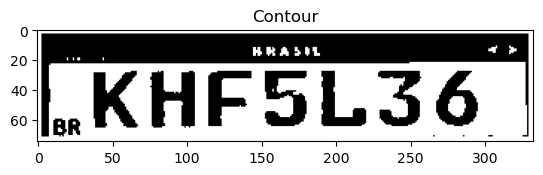

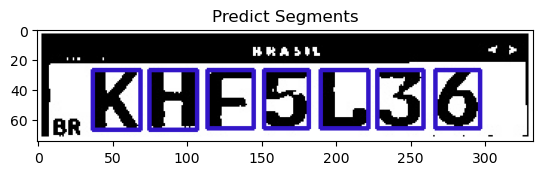

1/1 [==============================] - 0s 23ms/step
K
1/1 [==============================] - 0s 23ms/step
KH
1/1 [==============================] - 0s 23ms/step
KHF
1/1 [==============================] - 0s 24ms/step
KHF5
1/1 [==============================] - 0s 24ms/step
KHF5L
1/1 [==============================] - 0s 23ms/step
KHF5L3
1/1 [==============================] - 0s 23ms/step
KHF5L36


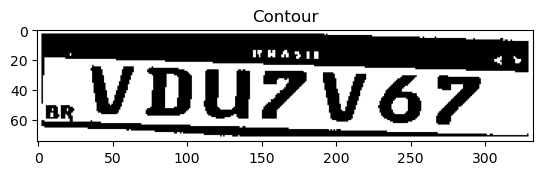

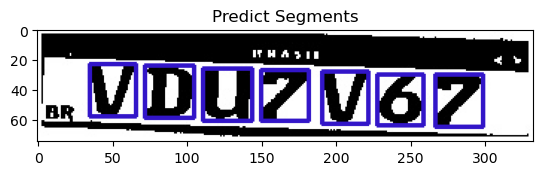

1/1 [==============================] - 0s 24ms/step
V
1/1 [==============================] - 0s 22ms/step
VD
1/1 [==============================] - 0s 22ms/step
VDU
1/1 [==============================] - 0s 22ms/step
VDU7
1/1 [==============================] - 0s 21ms/step
VDU7V
1/1 [==============================] - 0s 21ms/step
VDU7V6
1/1 [==============================] - 0s 26ms/step
VDU7V67


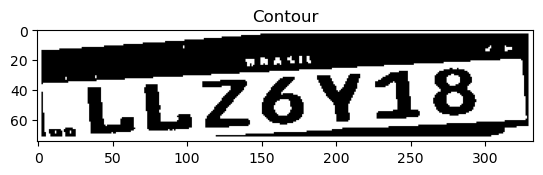

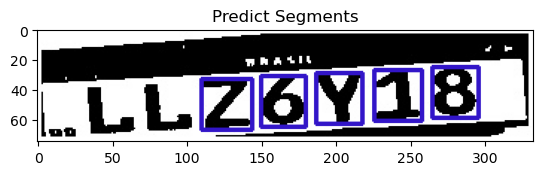

1/1 [==============================] - 0s 24ms/step
Z
1/1 [==============================] - 0s 23ms/step
Z6
1/1 [==============================] - 0s 22ms/step
Z6Y
1/1 [==============================] - 0s 22ms/step
Z6Y1
1/1 [==============================] - 0s 24ms/step
Z6Y18


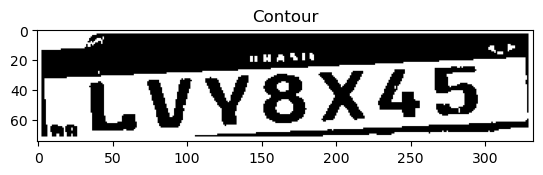

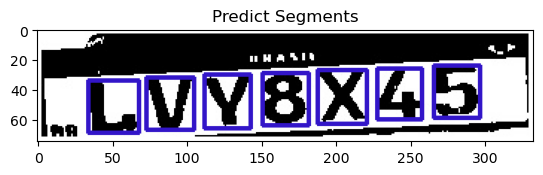

1/1 [==============================] - 0s 24ms/step
L
1/1 [==============================] - 0s 21ms/step
LV
1/1 [==============================] - 0s 23ms/step
LVY
1/1 [==============================] - 0s 24ms/step
LVY8
1/1 [==============================] - 0s 24ms/step
LVY8X
1/1 [==============================] - 0s 24ms/step
LVY8X4
1/1 [==============================] - 0s 23ms/step
LVY8X45


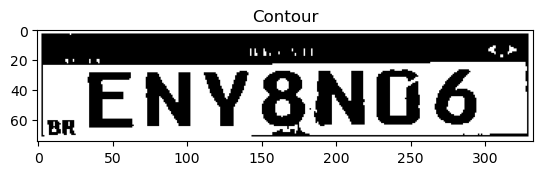

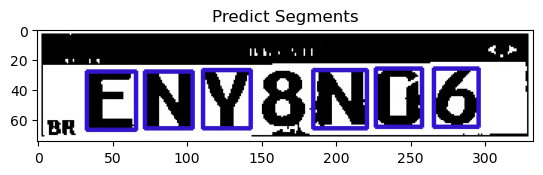

1/1 [==============================] - 0s 23ms/step
E
1/1 [==============================] - 0s 22ms/step
EN
1/1 [==============================] - 0s 22ms/step
ENY
1/1 [==============================] - 0s 22ms/step
ENYN
1/1 [==============================] - 0s 22ms/step
ENYN0
1/1 [==============================] - 0s 21ms/step
ENYN06


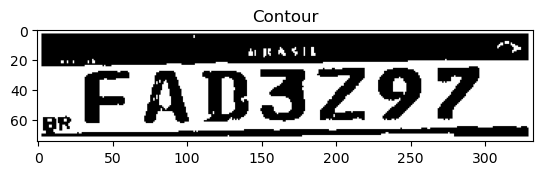

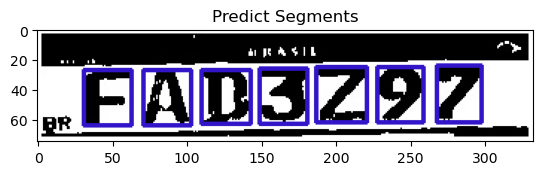

1/1 [==============================] - 0s 23ms/step
F
1/1 [==============================] - 0s 24ms/step
FA
1/1 [==============================] - 0s 24ms/step
FAB
1/1 [==============================] - 0s 23ms/step
FAB3
1/1 [==============================] - 0s 22ms/step
FAB3Z
1/1 [==============================] - 0s 24ms/step
FAB3Z9
1/1 [==============================] - 0s 23ms/step
FAB3Z97


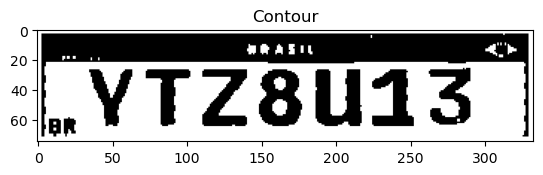

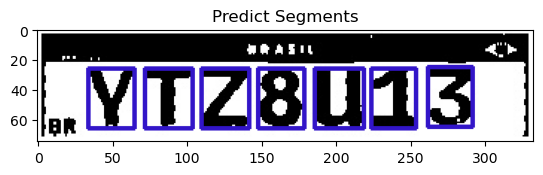

1/1 [==============================] - 0s 24ms/step
V
1/1 [==============================] - 0s 23ms/step
VT
1/1 [==============================] - 0s 22ms/step
VTZ
1/1 [==============================] - 0s 24ms/step
VTZ8
1/1 [==============================] - 0s 24ms/step
VTZ8U
1/1 [==============================] - 0s 23ms/step
VTZ8U1
1/1 [==============================] - 0s 23ms/step
VTZ8U13


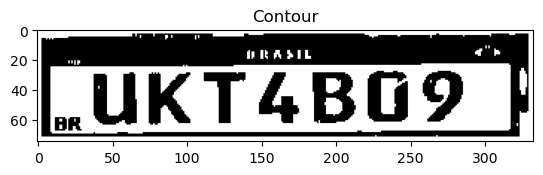

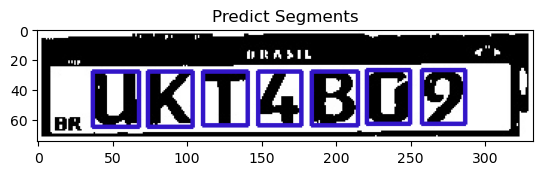

1/1 [==============================] - 0s 23ms/step
U
1/1 [==============================] - 0s 21ms/step
UK
1/1 [==============================] - 0s 21ms/step
UKT
1/1 [==============================] - 0s 26ms/step
UKT4
1/1 [==============================] - 0s 23ms/step
UKT4B
1/1 [==============================] - 0s 21ms/step
UKT4BG
1/1 [==============================] - 0s 22ms/step
UKT4BG9


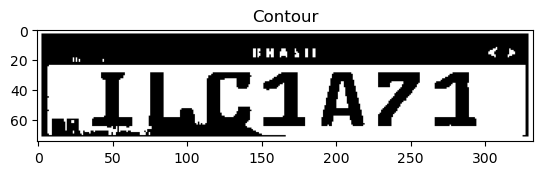

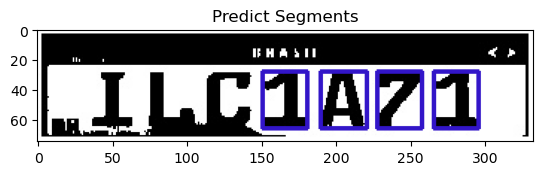

1/1 [==============================] - 0s 24ms/step
1
1/1 [==============================] - 0s 22ms/step
1A
1/1 [==============================] - 0s 22ms/step
1A7
1/1 [==============================] - 0s 22ms/step
1A71


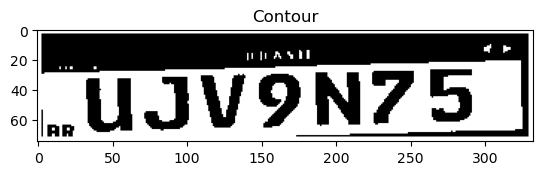

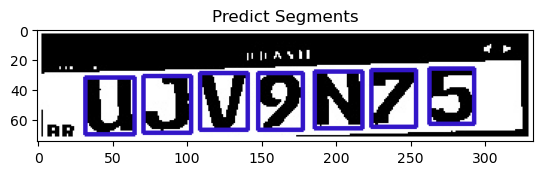

1/1 [==============================] - 0s 24ms/step
U
1/1 [==============================] - 0s 22ms/step
UJ
1/1 [==============================] - 0s 22ms/step
UJV
1/1 [==============================] - 0s 23ms/step
UJV9
1/1 [==============================] - 0s 27ms/step
UJV9N
1/1 [==============================] - 0s 25ms/step
UJV9N7
1/1 [==============================] - 0s 23ms/step
UJV9N75


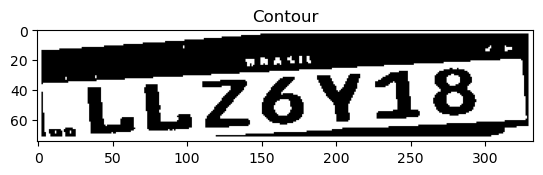

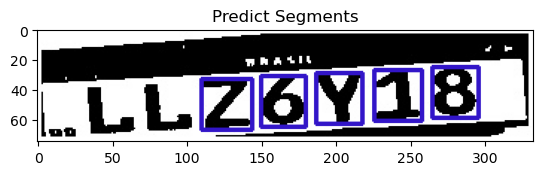

1/1 [==============================] - 0s 23ms/step
Z
1/1 [==============================] - 0s 24ms/step
Z6
1/1 [==============================] - 0s 25ms/step
Z6Y
1/1 [==============================] - 0s 23ms/step
Z6Y1
1/1 [==============================] - 0s 21ms/step
Z6Y18


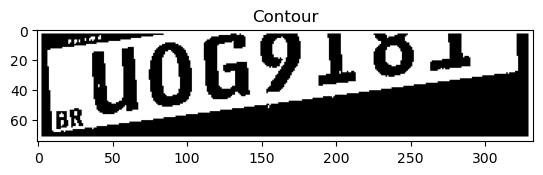

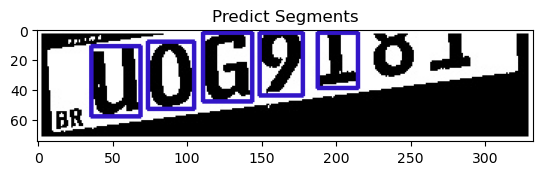

1/1 [==============================] - 0s 40ms/step
U
1/1 [==============================] - 0s 41ms/step
U0
1/1 [==============================] - 0s 39ms/step
U0G
1/1 [==============================] - 0s 37ms/step
U0G9
1/1 [==============================] - 0s 39ms/step
U0G9L


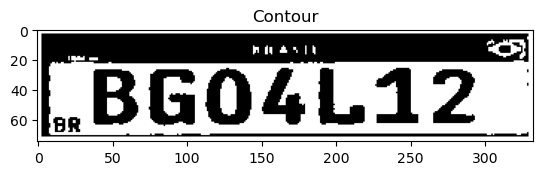

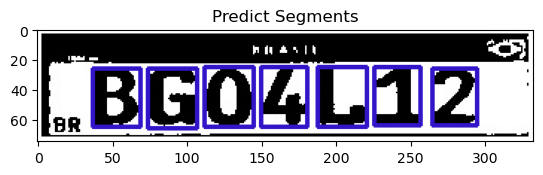

1/1 [==============================] - 0s 36ms/step
B
1/1 [==============================] - 0s 24ms/step
BG
1/1 [==============================] - 0s 23ms/step
BG0
1/1 [==============================] - 0s 22ms/step
BG04
1/1 [==============================] - 0s 23ms/step
BG04L
1/1 [==============================] - 0s 22ms/step
BG04L1
1/1 [==============================] - 0s 25ms/step
BG04L12


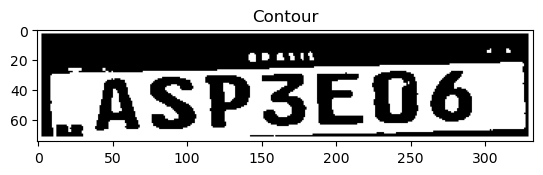

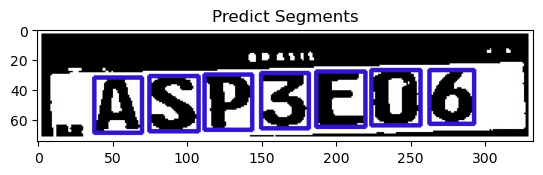

1/1 [==============================] - 0s 23ms/step
A
1/1 [==============================] - 0s 21ms/step
AS
1/1 [==============================] - 0s 22ms/step
ASP
1/1 [==============================] - 0s 22ms/step
ASP3
1/1 [==============================] - 0s 22ms/step
ASP3E
1/1 [==============================] - 0s 22ms/step
ASP3E0
1/1 [==============================] - 0s 24ms/step
ASP3E06


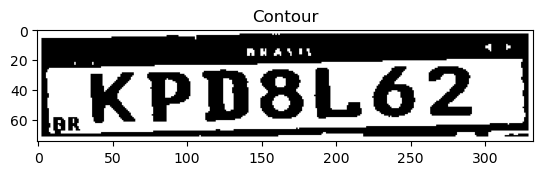

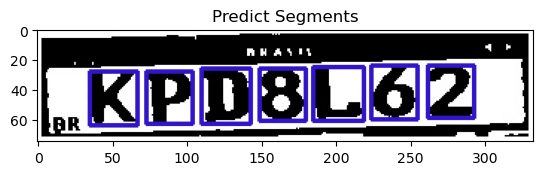

1/1 [==============================] - 0s 25ms/step
K
1/1 [==============================] - 0s 22ms/step
KP
1/1 [==============================] - 0s 26ms/step
KPD
1/1 [==============================] - 0s 24ms/step
KPD8
1/1 [==============================] - 0s 24ms/step
KPD8L
1/1 [==============================] - 0s 23ms/step
KPD8L6
1/1 [==============================] - 0s 23ms/step
KPD8L62


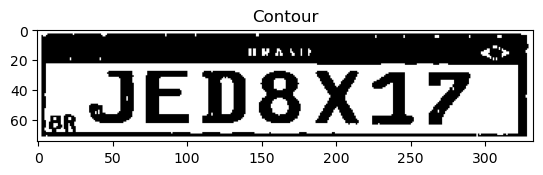

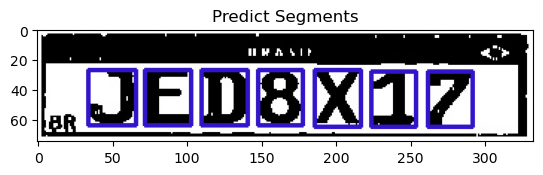

1/1 [==============================] - 0s 24ms/step
J
1/1 [==============================] - 0s 22ms/step
JE
1/1 [==============================] - 0s 22ms/step
JED
1/1 [==============================] - 0s 21ms/step
JED8
1/1 [==============================] - 0s 28ms/step
JED8X
1/1 [==============================] - 0s 22ms/step
JED8X1
1/1 [==============================] - 0s 22ms/step
JED8X17


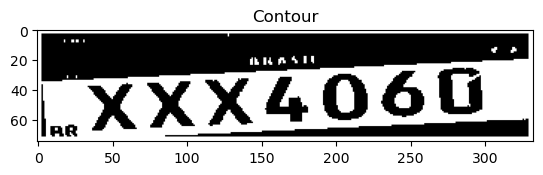

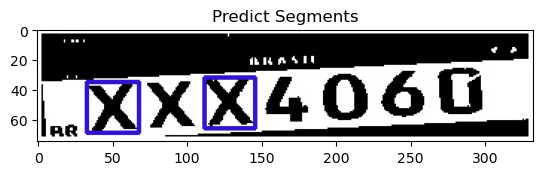

1/1 [==============================] - 0s 23ms/step
X
1/1 [==============================] - 0s 22ms/step
XX


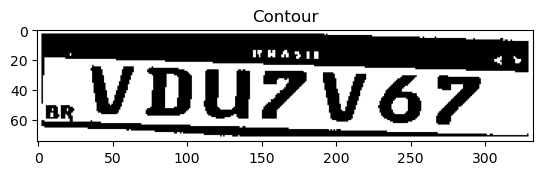

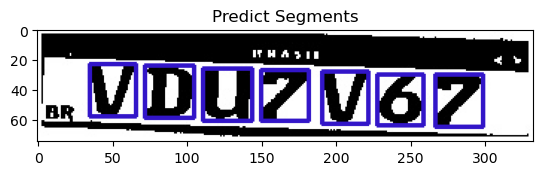

1/1 [==============================] - 0s 23ms/step
V
1/1 [==============================] - 0s 22ms/step
VD
1/1 [==============================] - 0s 23ms/step
VDU
1/1 [==============================] - 0s 22ms/step
VDU7
1/1 [==============================] - 0s 22ms/step
VDU7V
1/1 [==============================] - 0s 23ms/step
VDU7V6
1/1 [==============================] - 0s 23ms/step
VDU7V67


In [83]:
directory_path = '/kaggle/working/cropped/'
file_list = os.listdir(directory_path)
for cropped_image in file_list:
    cropped_image = '/kaggle/working/cropped/'+cropped_image
    cropped_image = Image.open(cropped_image)
    cropped = np.array(cropped_image)
    char=segment_characters(cropped)
    cols = len(char)
    final_string = ''
    for i,character in enumerate(char):
        title = np.array2string(predict_from_model(character,model,labels))
        final_string+=title.strip("'[]")
        print(final_string)

In [82]:
print(cropped)

/kaggle/working/cropped/35.jpg


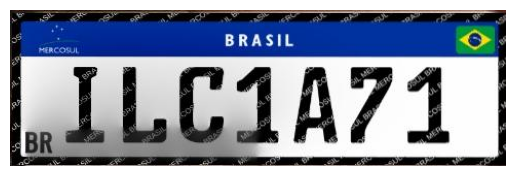

B RASIL


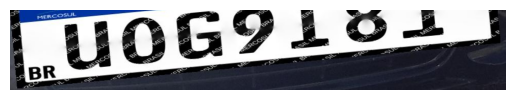

MERCOSUL


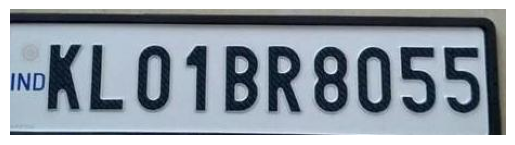

IND]


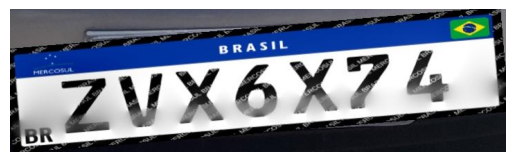

B RA SIL


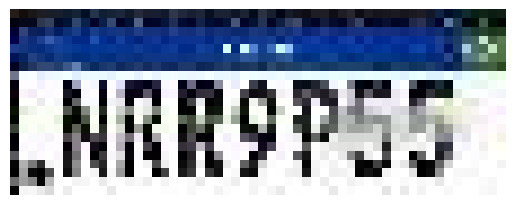

KeyboardInterrupt: 

In [9]:
import easyocr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

directory_path = '/kaggle/working/cropped/'
file_list = os.listdir(directory_path)
for cropped_image in file_list:
    cropped_image = '/kaggle/working/cropped/'+cropped_image
    cropped_image = Image.open(cropped_image)
    plt.imshow(cropped_image)
    plt.axis('off')  # This line hides the axis ticks and labels
    plt.show()
    reader = easyocr.Reader(['en'])
    result = reader.readtext(cropped_image)
    text = result[0][1]
    print(text)


In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
print(result)

In [17]:
pip install git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr

  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-dtx032fb/keras-ocr_2457a1ce03944fc68cdfce8985dadcf1
  Running command git clone --filter=blob:none --quiet https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-dtx032fb/keras-ocr_2457a1ce03944fc68cdfce8985dadcf1
  Resolved https://github.com/faustomorales/keras-ocr.git to commit b9c5a5871368fc337cbb6cd8f427b64a08626421
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of keras-ocr to determine which version is compatible with other requirements. This could take a while.
ERROR: Package 'keras-ocr' requires a different Python: 3.10.12 not in '<3.10,>=3.7.5'
Note: you may need to restart the kernel to use updated packages.


In [11]:
import keras_ocr
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'keras_ocr'

In [14]:
pip install keras_ocr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.0 MB/s eta 0:00:00
  Using cached editdistance-0.6.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (282 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
  Using cached essential_generators-1.0-py3-none-any.whl (9.5 MB)
  Using cached validators-0.20.0.tar.gz (30 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.7 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=5afaf86d4be21b9243a9be574fcee88685c6f5db7714f1c02d3ab80d9db69497
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
Note: you may need to restart the kernel to use updated packages.


In [16]:
import keras_ocr
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

ImportError: cannot import name 'QhullError' from 'scipy.spatial' (/opt/conda/lib/python3.10/site-packages/scipy/spatial/__init__.py)

In [15]:
pipeline = keras_ocr.pipeline.Pipeline()

NameError: name 'keras_ocr' is not defined

In [18]:
python --version

NameError: name 'python' is not defined

In [1]:
import shutil

folder_to_zip = "/kaggle/working/cropped"
output_zip_path = "/kaggle/working/your_output_filename.zip"

shutil.make_archive(output_zip_path.split('.')[0], 'zip', folder_to_zip)


'/kaggle/working/your_output_filename.zip'

In [2]:
from IPython.display import FileLink

FileLink(output_zip_path)


/kaggle/working/your_output_filename.zip